In [146]:
#default_exp prefect_flows.step2

In [147]:
from corradin_ovp_utils.catalog import test_data_catalog
from dask.distributed import Client
from corradin_ovp_utils.prefect_flows.step1 import tsv_result_partial, parquet_result_partial
from fastcore.test import test_eq_type

In [148]:
#export
from prefect.engine.results import LocalResult
from prefect import task, Flow, Parameter, unmapped, flatten
from prefect.engine.serializers import PandasSerializer
from prefect.tasks.shell import ShellTask
from prefect.tasks.templates import StringFormatter
from prefect.tasks.prefect import create_flow_run, StartFlowRun, RenameFlowRun
from prefect.engine.executors import DaskExecutor, LocalDaskExecutor, LocalExecutor
from prefect.engine import signals
from prefect import context
context.config.flows.checkpointing = True

import numpy as np
import pandas as pd
from typing import Union, List, Literal
import math

In [149]:
#export
from corradin_ovp_utils.prefect_flows.step1 import pairs_df_to_records, task_no_checkpoint
from corradin_ovp_utils.permutations import PermuteOddsRatio 
from corradin_ovp_utils.odds_ratio import reconstruct_genetic_info
from corradin_ovp_utils.MTC import MtcTable, StepwiseFilter
from corradin_ovp_utils.prefect_flows.step1 import (generate_summary_df,
SINGLE_PAIR_DATA_CACHE_TEMPLATE_WITHOUT_EXTENSION,
template_summary_df_target,
STEP1_FINAL_REPORT_FILE_NAME, ALL_GENO_DF_FILE_NAME)
from fastcore.basics import partialler

In [150]:
test_data_catalog = test_data_catalog.reload()
test_data_catalog.list()

['empty_geno_combo_after_permute_rs9610458_CC_rs77948203_AA',
 'permutation_error_rs134490_rs5762201_UKB',
 'genetic_file',
 'genetic_file_single',
 'genetic_file_case_control',
 'genetic_file_common_folder',
 'genetic_file_split_by_chrom',
 'genetic_file_bgen',
 'test_MS_chr22_pairs',
 'test_MS_chr22_snp_search_result',
 'test_MS_chr22_MTC_table',
 '100k_rsids_only_chrom_1',
 'sample_file',
 'sample_file_single',
 'sample_file_case_control',
 'test_UKB_sample_file',
 'geno_each_sample',
 'case_geno_each_sample',
 'control_geno_each_sample',
 'all_geno_df',
 'odds_ratio_df_rs9610458_rs77948203',
 'odds_ratio_df_rs134490_rs1004237',
 'summary_df_6_pairs_chrom_22']

In [151]:
pairs_df = test_data_catalog.load("test_MS_chr22_pairs")
pairs_df

,GWAS_id,outside_id,GWAS_chrom,outside_chrom
0,rs10853845,rs201338837,22,22
1,rs2253675,rs201338837,22,22
2,rs2331964,rs201338837,22,22
3,rs10853845,rs229502,22,22
4,rs10853845,rs183032559,22,22
5,rs10853845,rs79963419,22,22
6,rs134490,rs145985218,22,22
7,rs134490,rs202193982,22,22
8,rs4560284,rs201338837,22,22
9,rs134490,rs1004237,22,22


In [10]:
snp_search_result = test_data_catalog.load("test_MS_chr22_snp_search_result")
snp_search_result

,chrom,SNP_type,SNP_ID,found_in_genetic_file
0,22,GWAS_id,rs10853845,0
1,22,GWAS_id,rs2253675,0
2,22,GWAS_id,rs2331964,0
3,22,GWAS_id,rs134490,1
4,22,GWAS_id,rs4560284,0
5,22,GWAS_id,rs5756405,1
6,22,GWAS_id,rs9610458,1
7,22,outside_id,rs201338837,0
8,22,outside_id,rs229502,0
9,22,outside_id,rs183032559,0


In [11]:
all_geno_df = test_data_catalog.load("all_geno_df")
all_geno_df

,alleleA,alleleB,AA,AB,BB
id_col,,,,,
rs77948203,G,A,GG,AG,AA
rs1014626,C,T,CC,CT,TT
rs9610458,C,T,CC,CT,TT
rs5762201,A,G,AA,AG,GG
rs1004237,C,T,CC,CT,TT
rs134490,C,T,CC,CT,TT
rs4821519,G,C,GG,CG,CC
rs1003500,C,T,CC,CT,TT
rs5756405,A,G,AA,AG,GG


In [12]:
mtc_df = test_data_catalog.load("test_MS_chr22_MTC_table")
mtc_df

,GWAS_id,num_geno_combo_per_GWAS_id_filtered_more_than_4,threshold
0,rs134490,5,0.010000
1,rs5756405,6,0.008333
2,rs9610458,6,0.008333


## Task Definition

In [13]:
step1_final_report_df = tsv_result_partial(dir = "./test_prefect").read(STEP1_FINAL_REPORT_FILE_NAME).value
step1_final_report_df

,GWAS_id,outside_id,GWAS_chrom,outside_chrom,found_in_genetic_file_GWAS,found_in_genetic_file_outside,GWAS_id_geno,outside_id_geno,case_total_no_NA,case_total_with_NA,...,control_total_with_NA,odds_ratio_combo,odds_ratio_single,unique_samples_count_case,unique_samples_count_control,all_SNPs_found_in_genetic_file,non_zero_geno_combo_counts,geno_combo_passed_filter_1,pair_has_enough_geno_combo_passed_filter_1,geno_combo_passed_filter_2
0,rs10853845,rs201338837,22,22,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0,0
1,rs2253675,rs201338837,22,22,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0,0
2,rs2331964,rs201338837,22,22,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0,0
3,rs10853845,rs229502,22,22,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0,0
4,rs10853845,rs183032559,22,22,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,rs9610458,rs77948203,22,22,1,1,CT,AG,84489.0,86697.0,...,253792.0,0.99269,1.00076,5916.0,17441.0,1,6.0,1,1,1
67,rs9610458,rs77948203,22,22,1,1,CT,GG,84489.0,86697.0,...,253792.0,1.00275,1.00076,35725.0,104439.0,1,6.0,1,1,1
68,rs9610458,rs77948203,22,22,1,1,TT,AA,84489.0,86697.0,...,253792.0,0.88630,0.98439,132.0,436.0,1,NaN,0,0,0
69,rs9610458,rs77948203,22,22,1,1,TT,AG,84489.0,86697.0,...,253792.0,0.99814,0.98439,3403.0,9982.0,1,6.0,1,1,1


In [14]:
step1_final_report_df_filtered = step1_final_report_df.query("geno_combo_passed_filter_2 == 1")
step1_final_report_df_filtered

,GWAS_id,outside_id,GWAS_chrom,outside_chrom,found_in_genetic_file_GWAS,found_in_genetic_file_outside,GWAS_id_geno,outside_id_geno,case_total_no_NA,case_total_with_NA,...,control_total_with_NA,odds_ratio_combo,odds_ratio_single,unique_samples_count_case,unique_samples_count_control,all_SNPs_found_in_genetic_file,non_zero_geno_combo_counts,geno_combo_passed_filter_1,pair_has_enough_geno_combo_passed_filter_1,geno_combo_passed_filter_2
46,rs134490,rs5762201,22,22,1,1,CC,GG,85921.0,86697.0,...,253792.0,1.00445,1.01433,1147.0,3345.0,1,5.0,1,1,1
48,rs134490,rs5762201,22,22,1,1,CT,AG,85921.0,86697.0,...,253792.0,1.06638,1.00263,1762.0,4846.0,1,5.0,1,1,1
49,rs134490,rs5762201,22,22,1,1,CT,GG,85921.0,86697.0,...,253792.0,0.99298,1.00263,16136.0,47535.0,1,5.0,1,1,1
51,rs134490,rs5762201,22,22,1,1,TT,AG,85921.0,86697.0,...,253792.0,1.00456,0.99632,6285.0,18332.0,1,5.0,1,1,1
52,rs134490,rs5762201,22,22,1,1,TT,GG,85921.0,86697.0,...,253792.0,0.99637,0.99632,60258.0,176694.0,1,5.0,1,1,1
54,rs5756405,rs4821519,22,22,1,1,AA,CG,85436.0,86697.0,...,253792.0,0.98281,1.00124,3193.0,9505.0,1,6.0,1,1,1
55,rs5756405,rs4821519,22,22,1,1,AA,GG,85436.0,86697.0,...,253792.0,1.00586,1.00124,17800.0,51870.0,1,6.0,1,1,1
57,rs5756405,rs4821519,22,22,1,1,AG,CG,85436.0,86697.0,...,253792.0,1.00568,1.00257,6543.0,19055.0,1,6.0,1,1,1
58,rs5756405,rs4821519,22,22,1,1,AG,GG,85436.0,86697.0,...,253792.0,1.00045,1.00257,35377.0,103541.0,1,6.0,1,1,1
60,rs5756405,rs4821519,22,22,1,1,GG,CG,85436.0,86697.0,...,253792.0,0.97357,0.99545,3600.0,10813.0,1,6.0,1,1,1


In [15]:
pair_info = pairs_df_to_records.run(step1_final_report_df_filtered)[0]
pair_info_dict = pair_info.dict()
pair_info_dict

{'GWAS_id': 'rs134490',
 'outside_id': 'rs5762201',
 'GWAS_chrom': 22,
 'outside_chrom': 22,
 'mtc_threshold': None}

In [16]:
template_summary_df_target(pair_info=pair_info)

'snp_pairs_folders/rs134490/rs134490_rs5762201/single_pair_data_cache_df.tsv'

In [17]:
single_pair_df_path = template_summary_df_target(pair_info=pair_info, parquet = True)
single_pair_df = parquet_result_partial().read(location=single_pair_df_path).value
single_pair_df

,rs134490,rs5762201,odds_ratio_combo,odds_ratio_single,unique_samples_id_case,unique_samples_count_case,unique_samples_id_control,unique_samples_count_control,case_total_no_NA,case_total_with_NA,control_total_no_NA,control_total_with_NA
0,CC,AA,1.95281,1.01433,"[1041588, 1042820, 2995054, 4483197, 4522751, ...",6,"[1505529, 1519989, 2019724, 2053028, 3359698, ...",9,85921,86697,251672,253792
1,CC,AG,1.09855,1.01433,"[1078521, 1187600, 1223362, 1247155, 1417959, ...",114,"[1024531, 1064606, 1070868, 1077363, 1079574, ...",304,85921,86697,251672,253792
2,CC,GG,1.00445,1.01433,"[1002197, 1002513, 1010584, 1011406, 1013404, ...",1147,"[1001398, 1001703, 1004740, 1004784, 1007010, ...",3345,85921,86697,251672,253792
3,CT,AA,0.97636,1.00263,"[1186764, 1426246, 1451881, 1723507, 1755428, ...",43,"[1056898, 1065560, 1074468, 1101815, 1103983, ...",129,85921,86697,251672,253792
4,CT,AG,1.06638,1.00263,"[1006888, 1008110, 1010482, 1010781, 1011971, ...",1762,"[1001845, 1003947, 1004277, 1005483, 1007943, ...",4846,85921,86697,251672,253792
5,CT,GG,0.99298,1.00263,"[1000350, 1000505, 1000645, 1001890, 1002317, ...",16136,"[1000258, 1000377, 1000404, 1000496, 1000628, ...",47535,85921,86697,251672,253792
6,TT,AA,1.04182,0.99632,"[1023812, 1063950, 1092872, 1130075, 1135461, ...",170,"[1018820, 1025450, 1034420, 1047213, 1069912, ...",478,85921,86697,251672,253792
7,TT,AG,1.00456,0.99632,"[1000940, 1001562, 1003137, 1003450, 1003767, ...",6285,"[1000194, 1000564, 1000968, 1001106, 1001289, ...",18332,85921,86697,251672,253792
8,TT,GG,0.99637,0.99632,"[1000149, 1000151, 1000173, 1000201, 1000244, ...",60258,"[1000025, 1000038, 1000042, 1000056, 1000061, ...",176694,85921,86697,251672,253792


In [18]:
permute_odds_ratio_obj = PermuteOddsRatio(summary_df = single_pair_df, single_rsid=pair_info.GWAS_id, all_geno_df=all_geno_df, combo_rsid_list= [pair_info.GWAS_id, pair_info.outside_id], permute_rsid= pair_info.outside_id)
permute_odds_ratio_obj

In [ ]:
permute_odds_ratio_obj.perform_permutation(n_iterations=1000)

In [22]:
permute_odds_ratio_obj.report_df

,rs134490,rs5762201,odds_ratio_single,odds_ratio_combo,iterations,num_perm_lower,num_perm_higher,combo_higher_than_single_binary,combo_higher_than_single_str,iter_used_for_pval,pval
0,CC,AA,1.01433,1.95281,12,9,3,1,higher,3,0.250000
1,CC,AG,1.01433,1.09855,12,9,3,1,higher,3,0.250000
2,CC,GG,1.01433,1.00445,12,3,9,0,lower,3,0.250000
3,CT,AA,1.00263,0.97636,12,6,6,0,lower,6,0.500000
4,CT,AG,1.00263,1.06638,12,12,0,1,higher,0,0.083333
5,CT,GG,1.00263,0.99298,12,0,12,0,lower,0,0.083333
6,TT,AA,0.99632,1.04182,12,8,4,1,higher,4,0.333333
7,TT,AG,0.99632,1.00456,12,7,5,1,higher,5,0.416667
8,TT,GG,0.99632,0.99637,12,5,7,1,higher,7,0.583333


In [22]:
report_df = permute_odds_ratio_obj.report_df
report_df_melted = generate_summary_df.run(report_df, pair_info)

In [23]:
report_df_melted

,GWAS_id,GWAS_id_geno,outside_id,outside_id_geno,combo_higher_than_single_binary,combo_higher_than_single_str,iter_used_for_pval,iterations,num_perm_higher,num_perm_lower,odds_ratio_combo,odds_ratio_single,pval
0,rs134490,CC,rs5762201,AA,0,lower,0,1000,0,0,NaN,1.01473,0.001
1,rs134490,CC,rs5762201,AG,0,lower,43,1000,319,43,0.59027,1.01473,0.043
2,rs134490,CC,rs5762201,GG,1,higher,57,1000,57,303,1.06202,1.01473,0.057
3,rs134490,CT,rs5762201,AA,0,lower,2,1000,329,2,0.33811,0.94811,0.002
4,rs134490,CT,rs5762201,AG,0,lower,148,1000,463,148,0.80612,0.94811,0.148
5,rs134490,CT,rs5762201,GG,1,higher,406,1000,406,170,0.97652,0.94811,0.406
6,rs134490,TT,rs5762201,AA,0,lower,48,1000,242,48,0.86647,1.04957,0.048
7,rs134490,TT,rs5762201,AG,0,lower,151,1000,473,151,0.98662,1.04957,0.151
8,rs134490,TT,rs5762201,GG,0,lower,433,1000,163,433,1.04709,1.04957,0.433


In [24]:
mtc_table_obj = MtcTable(mtc_df, "threshold")
mtc_table_obj

In [25]:
stepwise_filter_obj = StepwiseFilter(mtc_table_obj, 99)
stepwise_filter_obj.get_c_i(1200, 0.000833)

(-0.001312343196326083, 0.002978343196326083)

In [26]:
_, report_df_melted["ci_neg"],  report_df_melted["c_i_pos"], report_df_melted["mtc_threshold"], report_df_melted["need_more_perm"], report_df_melted["status"] = stepwise_filter_obj.get_compare_info_list_vectorized(report_df_melted["iterations"], report_df_melted["pval"], report_df_melted["GWAS_id"], report_df_melted["combo_higher_than_single_str"])
report_df_melted

,GWAS_id,GWAS_id_geno,outside_id,outside_id_geno,combo_higher_than_single_binary,combo_higher_than_single_str,iter_used_for_pval,iterations,num_perm_higher,num_perm_lower,odds_ratio_combo,odds_ratio_single,pval,ci_neg,c_i_pos,mtc_threshold,need_more_perm,status
0,rs134490,CC,rs5762201,AA,0,lower,0,1000,0,0,NaN,1.01473,0.001,-0.001575,0.003575,0.01,False,sig_lower
1,rs134490,CC,rs5762201,AG,0,lower,43,1000,319,43,0.59027,1.01473,0.043,0.026475,0.059525,0.01,False,non_sig
2,rs134490,CC,rs5762201,GG,1,higher,57,1000,57,303,1.06202,1.01473,0.057,0.038114,0.075886,0.01,False,non_sig
3,rs134490,CT,rs5762201,AA,0,lower,2,1000,329,2,0.33811,0.94811,0.002,-0.001639,0.005639,0.01,False,sig_lower
4,rs134490,CT,rs5762201,AG,0,lower,148,1000,463,148,0.80612,0.94811,0.148,0.119073,0.176927,0.01,False,non_sig
5,rs134490,CT,rs5762201,GG,1,higher,406,1000,406,170,0.97652,0.94811,0.406,0.365996,0.446004,0.01,False,non_sig
6,rs134490,TT,rs5762201,AA,0,lower,48,1000,242,48,0.86647,1.04957,0.048,0.030587,0.065413,0.01,False,non_sig
7,rs134490,TT,rs5762201,AG,0,lower,151,1000,473,151,0.98662,1.04957,0.151,0.121833,0.180167,0.01,False,non_sig
8,rs134490,TT,rs5762201,GG,0,lower,433,1000,163,433,1.04709,1.04957,0.433,0.392637,0.473363,0.01,False,non_sig


In [27]:
final_report_df_melted = report_df_melted.merge(step1_final_report_df, how = "left")
final_report_df_melted

,GWAS_id,GWAS_id_geno,outside_id,outside_id_geno,combo_higher_than_single_binary,combo_higher_than_single_str,iter_used_for_pval,iterations,num_perm_higher,num_perm_lower,...,case_total_with_NA,control_total_no_NA,control_total_with_NA,unique_samples_count_case,unique_samples_count_control,all_SNPs_found_in_genetic_file,non_zero_geno_combo_counts,geno_combo_passed_filter_1,pair_has_enough_geno_combo_passed_filter_1,geno_combo_passed_filter_2
0,rs134490,CC,rs5762201,AA,0,lower,0,1000,0,0,...,9772.0,4496.0,5175.0,NaN,NaN,1,NaN,0,0,0
1,rs134490,CC,rs5762201,AG,0,lower,43,1000,319,43,...,9772.0,4496.0,5175.0,12.0,11.0,1,NaN,0,0,0
2,rs134490,CC,rs5762201,GG,1,higher,57,1000,57,303,...,9772.0,4496.0,5175.0,231.0,118.0,1,5.0,1,1,1
3,rs134490,CT,rs5762201,AA,0,lower,2,1000,329,2,...,9772.0,4496.0,5175.0,5.0,8.0,1,NaN,0,0,0
4,rs134490,CT,rs5762201,AG,0,lower,148,1000,463,148,...,9772.0,4496.0,5175.0,166.0,111.0,1,5.0,1,1,1
5,rs134490,CT,rs5762201,GG,1,higher,406,1000,406,170,...,9772.0,4496.0,5175.0,2106.0,1161.0,1,5.0,1,1,1
6,rs134490,TT,rs5762201,AA,0,lower,48,1000,242,48,...,9772.0,4496.0,5175.0,8.0,5.0,1,NaN,0,0,0
7,rs134490,TT,rs5762201,AG,0,lower,151,1000,473,151,...,9772.0,4496.0,5175.0,505.0,277.0,1,5.0,1,1,1
8,rs134490,TT,rs5762201,GG,0,lower,433,1000,163,433,...,9772.0,4496.0,5175.0,5268.0,2805.0,1,5.0,1,1,1


In [152]:
#export
parquet_result = LocalResult("{step1_folder_path}", serializer = PandasSerializer("parquet"))
tsv_result_partial = LocalResult(serializer = PandasSerializer("csv",
                                                                         serialize_kwargs={"sep":"\t", "index": False},
                                                                         deserialize_kwargs={"sep": "\t"}))
mtc_file_name = "MTCFilterResult/1_MTC_table.tsv"
iteration_result_step_file_template = "{output_folder_path_resolved}/permutation_results/{GWAS_id}/{GWAS_id}_{total_iterations}_total_iterations"

@task_no_checkpoint(target = partialler(template_summary_df_target, parquet=True), result = parquet_result)
def read_parquet_single_pair_cache_df(pair_info):
#     single_pair_df_path = template_summary_df_target(pair_info=pair_info, parquet = True)
#     single_pair_df = parquet_result_partial().read(location=single_pair_df_path).value
    return single_pair_df

@task_no_checkpoint
def load_file(file_path, file_type="csv"):
    if file_type == "csv":
        result = LocalResult(serializer = PandasSerializer("csv", serialize_kwargs={"sep":"\t", "index": False}, deserialize_kwargs={"sep": "\t"})).read(location=file_path)
    if file_type == "parquet":
        result = LocalResult(serializer = PandasSerializer("parquet")).read(location=file_path)
    
    df = result.value
    return df

@task_no_checkpoint
def get_pairs_for_step2(step1_final_report_df, GWAS_ids : Union[str, List[str]] = None, outside_ids: Union[str, List[str]] = None ):
    step1_final_report_df_filtered = step1_final_report_df.query("geno_combo_passed_filter_2 == 1")
    if GWAS_ids:
        step1_final_report_df_filtered = step1_final_report_df_filtered.query("GWAS_id == @GWAS_ids")
    if outside_ids:
        step1_final_report_df_filtered = step1_final_report_df_filtered.query("GWAS_id == @outside_ids")
    pair_info_list = pairs_df_to_records.run(step1_final_report_df_filtered)
    return pair_info_list

@task_no_checkpoint
def calculate_num_batches(total_iterations:int, batch_size = 1_000):
    num_batches = math.ceil(total_iterations/batch_size)
    return num_batches

@task_no_checkpoint
def get_permute_odds_ratio_object(single_pair_df, pair_info, all_geno_df, num_batches):
    
    #if the sample ids are loaded as string it will cause error downstream
    assert type(single_pair_df.loc[0, "unique_samples_id_case"]) == np.ndarray
    return [PermuteOddsRatio(summary_df = single_pair_df, single_rsid=pair_info.GWAS_id, all_geno_df=all_geno_df, combo_rsid_list= [pair_info.GWAS_id, pair_info.outside_id], permute_rsid= pair_info.outside_id)\
            for batch in range(num_batches)]
            
@task_no_checkpoint
def get_duplicated_pair_info(pair_info, num_batches):
    return [pair_info for batch in range(num_batches)]


@task(target="{output_folder_path_resolved}/permutation_results/{pair_info.GWAS_id}/{pair_info.outside_id}/{pair_info.GWAS_id}_{pair_info.outside_id}_{total_iterations}_total_iterations_{n_iterations}_{map_index}",
      result = tsv_result_partial,
      checkpoint = True)
def perform_permutation(*, permute_odds_ratio_obj: PermuteOddsRatio, pair_info,
                        n_iterations: int,
                        total_iterations: int,
                        output_folder_path_resolved:str):
    iterations_performed = n_iterations if n_iterations < total_iterations else total_iterations
    permute_odds_ratio_obj.perform_permutation(n_iterations=iterations_performed)
    return permute_odds_ratio_obj.report_df


def resolve_iteration_result_step_file_name(*, output_folder_path_resolved, **kwargs):
    if kwargs["GWAS_id"] is None:
        iteration_result_step_file_name = "{output_folder_path_resolved}/permutation_results/all_GWAS_{total_iterations}_total_iterations_permutation_result".format(output_folder_path_resolved = output_folder_path_resolved, **kwargs)
    else:
        iteration_result_step_file_name = "{output_folder_path_resolved}/permutation_results/{GWAS_id}/{GWAS_id}_{total_iterations}_total_iterations".format(output_folder_path_resolved = output_folder_path_resolved, **kwargs)
    return iteration_result_step_file_name

@task_no_checkpoint
def get_previous_steps_result(iteration_steps: List[int], total_iterations: int, GWAS_id: str, output_folder_path_resolved):
    if total_iterations not in iteration_steps:
        raise signals.FAIL
    current_step_index = iteration_steps.index(total_iterations)
    previous_steps = iteration_steps[:current_step_index]
    previous_steps_result_files = [tsv_result_partial.read(location = resolve_iteration_result_step_file_name(output_folder_path_resolved = output_folder_path_resolved,
                                                                                                                   GWAS_id = GWAS_id,
                                                                                                                   total_iterations = iter_step)).value for iter_step in previous_steps]
    return previous_steps_result_files
    

# def template_permutation_df_target(pair_info):

# @task(target="{output_folder_path_resolved}/all_permutation_results", result = tsv_result_partial())
# def combine_results(report_dfs, output_folder_path_resolved):
#     all_results_df = pd.concat(report_dfs)
#     return all_results_df


@task(target=resolve_iteration_result_step_file_name, result = tsv_result_partial ,checkpoint = True)
def process_report_df(report_df_melted_list:List[pd.DataFrame],
                      mtc_df,
                      step1_final_report_df,
                      output_folder_path_resolved,
                      previous_steps_result_files: List[pd.DataFrame]):
   
    mtc_table_obj = MtcTable(mtc_df, "threshold")
    stepwise_filter_obj = StepwiseFilter(mtc_table_obj, 99)
    
    all_report_df_melted = pd.concat( previous_steps_result_files + report_df_melted_list)
    
    
    
    group_by_cols = ["GWAS_id", "GWAS_id_geno", "outside_id", "outside_id_geno", "combo_higher_than_single_str"]
    
    agg_df =  all_report_df_melted.groupby(group_by_cols)
    agg_df = agg_df.agg({"iterations": "sum",
                "iter_used_for_pval": "sum",
                 "num_perm_lower":"sum",
                 "num_perm_higher":"sum",
                }).reset_index()#.add_prefix("combined_").reset_index()

    agg_df["pval"] = agg_df["iter_used_for_pval"] / agg_df["iterations"]
    agg_df["pval"] = np.where(agg_df["pval"] != 0, agg_df["pval"].astype(float), 1/agg_df["iterations"].astype(float))
    
    #step1_final_report_df_filtered = step1_final_report_df.query("geno_combo_passed_filter_2 == 1")
    _, agg_df["ci_neg"],  agg_df["c_i_pos"], agg_df["mtc_threshold"], agg_df["need_more_perm"], agg_df["status"] = stepwise_filter_obj.get_compare_info_list_vectorized(agg_df["iterations"], 
    agg_df["pval"], 
    agg_df["GWAS_id"], 
    agg_df["combo_higher_than_single_str"])
    

    
    #all_report_df_melted = all_report_df_melted.drop(columns = ["iterations", "iter_used_for_pval", "num_perm_lower", "num_perm_higher", "pval"]).drop_duplicates()
    # all_report_df_melted = all_report_df_melted[["GWAS_id", "GWAS_id_geno", "outside_id", "outside_id_geno", 'GWAS_chrom', 'all_SNPs_found_in_genetic_file', 'case_total_no_NA',
    #    'case_total_with_NA', 'combo_higher_than_single_binary',  "combo_higher_than_single_str",
    #    'control_total_no_NA', 'control_total_with_NA',
    #    'found_in_genetic_file_GWAS', 'found_in_genetic_file_outside',
    #    'geno_combo_passed_filter_1', 'geno_combo_passed_filter_2',
    # 'odds_ratio_combo', 'odds_ratio_single',
    #    'outside_chrom', 'pair_has_enough_geno_combo_passed_filter_1',
    #    'unique_samples_count_case', 'unique_samples_count_control']].dropna().drop_duplicates()
    
    #breakpoint()
    all_report_df_melted = all_report_df_melted[['GWAS_id', 'GWAS_id_geno', 'outside_id', 'outside_id_geno',
       'combo_higher_than_single_binary', 'combo_higher_than_single_str',
       'odds_ratio_combo', 'odds_ratio_single']].dropna().drop_duplicates()
    #breakpoint()
    all_report_df_melted = all_report_df_melted.merge(agg_df)
    

    
    #final_report_df = report_df_melted.merge(step1_final_report_df_filtered, how = "left")
    final_report_df = step1_final_report_df.merge(all_report_df_melted, how = "right")
    return final_report_df

@task_no_checkpoint
def determine_if_needs_more_perm(final_report_df):
    need_more_perm = (final_report_df.query("geno_combo_passed_filter_2 == 1")["status"] == "more_perm").any()
    return need_more_perm, final_report_df.query("geno_combo_passed_filter_2 == 1 and status == 'more_perm'")

@task_no_checkpoint
def resolve_output_folder_path(step1_folder_path, output_folder_path):
    if output_folder_path is None:
        output_folder_path_resolved = step1_folder_path
    else:
        output_folder_path_resolved = output_folder_path
    return output_folder_path_resolved

file_path_template = StringFormatter(name = "create_file_path", template = "{folder_path}/{file_name}")
flow_run_name_template= StringFormatter(name = "create_flow_name", template = "{GWAS_id}_total_iter_{total_iterations}")
template_summary_df_target_task = task()(template_summary_df_target)



In [47]:
get_permute_odds_ratio_object.run(single_pair_df, pair_info, all_geno_df= all_geno_df, total_iterations = 10_000)

NameError: name 'single_pair_df' is not defined

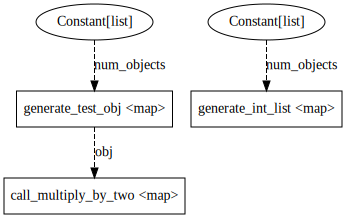

In [7]:
class TestObj():
    
    def multiply_by_two(self, num):
        return num * 2
    
@task
def generate_test_obj(num_objects):
    return [TestObj() for i in range(num_objects)]
            
@task
def generate_int_list(num_objects):
    return [num_object for num_object in range(num_objects)]

@task
def call_multiply_by_two(obj, num):
    return obj.multiply_by_two(num)

with Flow("test_flow") as test_flow:
    int_arr = [1, 4, 6, 10]
    #generate_test_obj_result = generate_test_obj.map(num_objects= int_arr)
    objects = generate_test_obj.map(num_objects= int_arr) #generate_test_obj_result["objects"]
    int_list = generate_int_list.map(num_objects = int_arr) #gene generate_test_obj_result["int_list"]
    result = call_multiply_by_two.map(obj = flatten(objects), num = unmapped(3))
    
test_flow.visualize()

[2021-11-10 16:04:31-0500] INFO - prefect.FlowRunner | Beginning Flow run for 'test_flow'
[2021-11-10 16:04:31-0500] INFO - prefect.TaskRunner | Task 'generate_int_list': Starting task run...
[2021-11-10 16:04:31-0500] INFO - prefect.TaskRunner | Task 'generate_int_list': Finished task run for task with final state: 'Mapped'
[2021-11-10 16:04:31-0500] INFO - prefect.TaskRunner | Task 'generate_int_list[0]': Starting task run...
[2021-11-10 16:04:31-0500] INFO - prefect.TaskRunner | Task 'generate_int_list[0]': Finished task run for task with final state: 'Success'
[2021-11-10 16:04:31-0500] INFO - prefect.TaskRunner | Task 'generate_int_list[1]': Starting task run...
[2021-11-10 16:04:31-0500] INFO - prefect.TaskRunner | Task 'generate_int_list[1]': Finished task run for task with final state: 'Success'
[2021-11-10 16:04:31-0500] INFO - prefect.TaskRunner | Task 'generate_int_list[2]': Starting task run...
[2021-11-10 16:04:31-0500] INFO - prefect.TaskRunner | Task 'generate_int_list[2

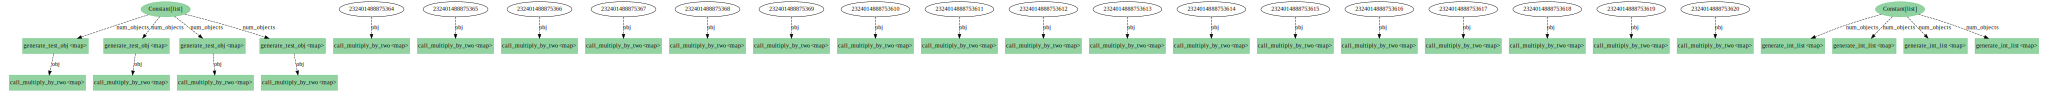

In [14]:
test_flow_state = test_flow.run()
test_flow.visualize(flow_state = test_flow_state)

In [70]:
listcontext.keys()

KeysView(<Context>)

In [87]:
test_flow_state.result[objects].result

[[<__main__.TestObj at 0x14cbe8e30af0>],

In [89]:
test_flow_state.result[result].result

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

In [37]:
#export
def dynamic_executor():#executor_type: Literal["local_dask", "cluster_dask", "default"] = "default"):
    executor_type = context.parameters["executor"]
    if executor_type == "local_dask":
        executor = LocalDaskExecutor()
    elif executor_type == "cluster_dask":
        executor = DaskExecutor('tcp://172.18.102.9:8789')
    elif executor_type == "default":
        executor = None
    return executor
        
        
    
    

## Flow Definition

In [153]:
#export
from prefect.executors import DaskExecutor
dask_executor = DaskExecutor(address="tcp://172.18.102.9:8789")

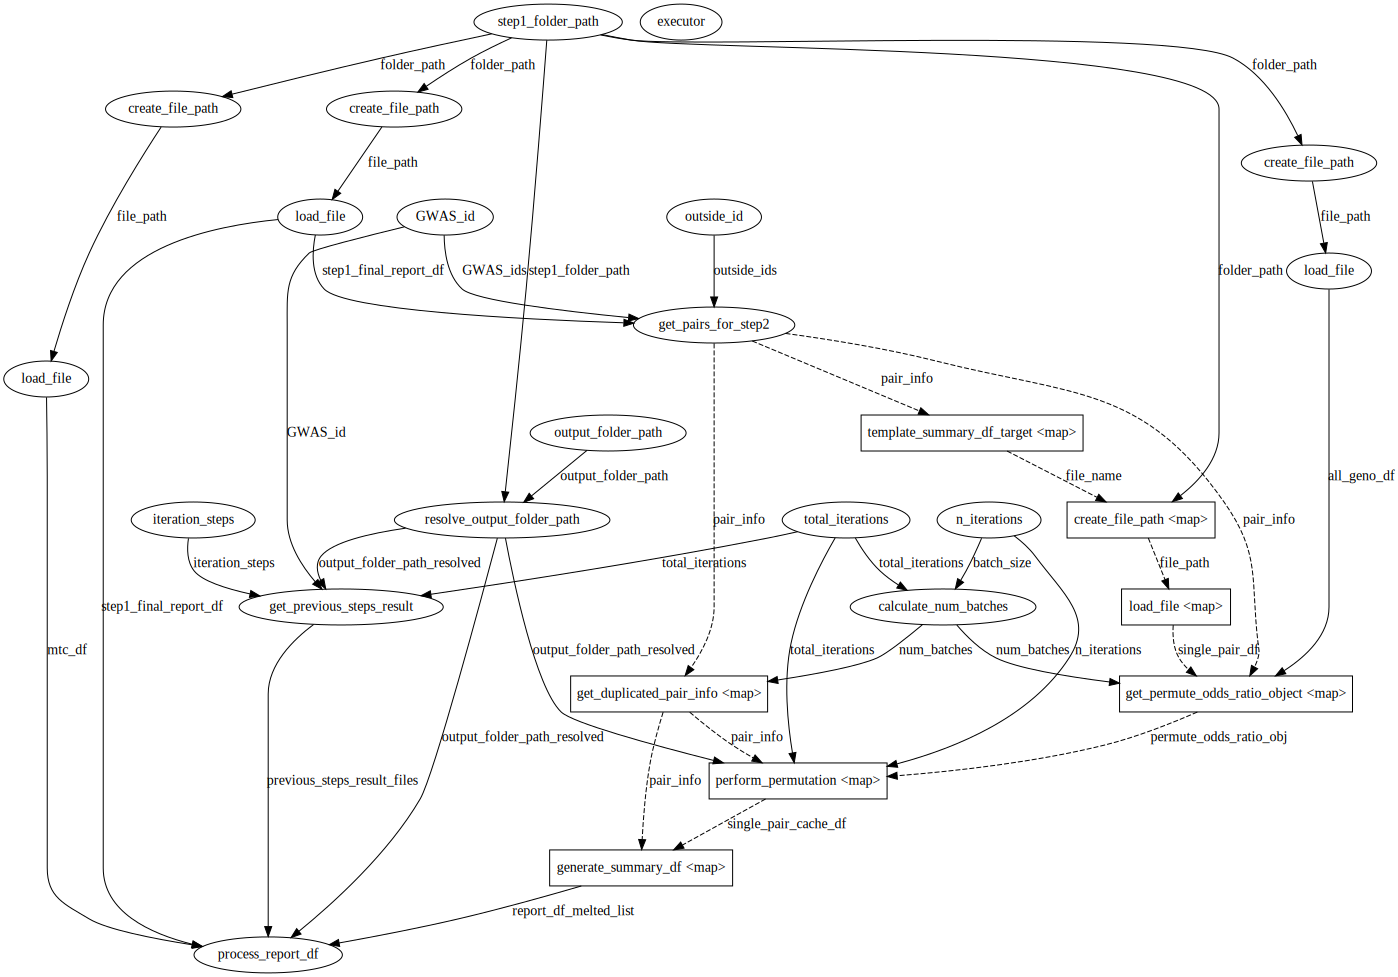

In [154]:
#export

#maximum iter
#
with Flow("OVP_step2", result = LocalResult(dir = "./prefect_can_delete"), executor =dask_executor ) as dev_flow:
#with Flow("OVP_step2", result = LocalResult(dir = "./prefect_can_delete")) as dev_flow:
    step1_folder_path = Parameter("step1_folder_path")
    output_folder_path = Parameter("output_folder_path", default = None)
    GWAS_id = Parameter("GWAS_id", default = None)
    outside_id = Parameter("outside_id", default = None)
    n_iterations = Parameter("n_iterations")
    total_iterations = Parameter("total_iterations")
    iteration_steps = Parameter("iteration_steps", default = [1_000, 10_000, 100_000, 1_000_000])
    dev_flow.add_task(Parameter("executor", default = "default"))
    
#     flow_run_name = flow_run_name_template()
#     new_name = RenameFlowRun(flow_run_id=context.get("flow_run_id"),flow_run_name= flow_run_name)()
    output_folder_path_resolved = resolve_output_folder_path(step1_folder_path, output_folder_path=output_folder_path)
    
    step1_final_report_file_path = file_path_template(folder_path = step1_folder_path, file_name = STEP1_FINAL_REPORT_FILE_NAME)
    all_geno_df_file_path = file_path_template(folder_path = step1_folder_path, file_name = ALL_GENO_DF_FILE_NAME)
    mtc_df_file_path = file_path_template(folder_path = step1_folder_path, file_name = mtc_file_name)
    
    step1_final_report_df = load_file(step1_final_report_file_path)
    all_geno_df = load_file(all_geno_df_file_path, file_type = "parquet")
    mtc_df = load_file(mtc_df_file_path)
    
    pair_info_list = get_pairs_for_step2(step1_final_report_df, GWAS_ids = GWAS_id, outside_ids= outside_id)
    single_pair_df_paths = template_summary_df_target_task.map(pair_info = pair_info_list, parquet = unmapped(True))
    single_pair_dfs = load_file.map(file_path = file_path_template.map(folder_path = unmapped(step1_folder_path), file_name = single_pair_df_paths), file_type = unmapped("parquet"))
    
    num_batches = calculate_num_batches(total_iterations= total_iterations, batch_size= n_iterations)
    permute_odds_ratio_objects = get_permute_odds_ratio_object.map(single_pair_df=single_pair_dfs,
                                                                pair_info = pair_info_list,
                                                                all_geno_df= unmapped(all_geno_df),
                                                                num_batches = unmapped(num_batches))
    duplicated_pair_info_list = get_duplicated_pair_info.map(pair_info = pair_info_list,
                                                             num_batches = unmapped(num_batches))
    
    report_dfs = perform_permutation.map(permute_odds_ratio_obj= flatten(permute_odds_ratio_objects),
                                         n_iterations=unmapped(n_iterations),
                                         total_iterations=unmapped(total_iterations),
                                         pair_info = flatten(duplicated_pair_info_list),
                                         output_folder_path_resolved=unmapped(output_folder_path_resolved))
    
    report_dfs_melted = generate_summary_df.map(single_pair_cache_df = report_dfs, pair_info = flatten(duplicated_pair_info_list))

    # final_report_dfs = process_report_df.map(report_df = report_dfs_melted, #pair_info = flatten(duplicated_pair_info_list),
    #                                          mtc_df=unmapped(mtc_df),
    #                                          step1_final_report_df= unmapped(step1_final_report_df))
    
    previous_steps_result_files = get_previous_steps_result(iteration_steps= iteration_steps, total_iterations = total_iterations, GWAS_id = GWAS_id, output_folder_path_resolved = output_folder_path_resolved)
    final_report_dfs = process_report_df(report_df_melted_list= report_dfs_melted, mtc_df = mtc_df, step1_final_report_df = step1_final_report_df, output_folder_path_resolved = output_folder_path_resolved, previous_steps_result_files = previous_steps_result_files)
    
    #read_parquet_single_pair_cache_df()

#flow.add_task(ShellTask("pwd"))
dev_flow.visualize()

In [79]:
dev_flow.executor = None

[2021-12-12 11:41:42-0500] INFO - prefect.FlowRunner | Beginning Flow run for 'OVP_step2'


INFO:prefect.FlowRunner:Beginning Flow run for 'OVP_step2'


[2021-12-12 11:41:42-0500] INFO - prefect.TaskRunner | Task 'total_iterations': Starting task run...


INFO:prefect.TaskRunner:Task 'total_iterations': Starting task run...


[2021-12-12 11:41:42-0500] INFO - prefect.TaskRunner | Task 'total_iterations': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'total_iterations': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:42-0500] INFO - prefect.TaskRunner | Task 'outside_id': Starting task run...


INFO:prefect.TaskRunner:Task 'outside_id': Starting task run...


[2021-12-12 11:41:42-0500] INFO - prefect.TaskRunner | Task 'outside_id': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'outside_id': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:42-0500] INFO - prefect.TaskRunner | Task 'executor': Starting task run...


INFO:prefect.TaskRunner:Task 'executor': Starting task run...


[2021-12-12 11:41:42-0500] INFO - prefect.TaskRunner | Task 'executor': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'executor': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:42-0500] INFO - prefect.TaskRunner | Task 'step1_folder_path': Starting task run...


INFO:prefect.TaskRunner:Task 'step1_folder_path': Starting task run...


[2021-12-12 11:41:42-0500] INFO - prefect.TaskRunner | Task 'step1_folder_path': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'step1_folder_path': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:42-0500] INFO - prefect.TaskRunner | Task 'GWAS_id': Starting task run...


INFO:prefect.TaskRunner:Task 'GWAS_id': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'GWAS_id': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'GWAS_id': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'output_folder_path': Starting task run...


INFO:prefect.TaskRunner:Task 'output_folder_path': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'output_folder_path': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'output_folder_path': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'create_file_path': Starting task run...


INFO:prefect.TaskRunner:Task 'create_file_path': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'create_file_path': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'create_file_path': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'iteration_steps': Starting task run...


INFO:prefect.TaskRunner:Task 'iteration_steps': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'iteration_steps': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'iteration_steps': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'n_iterations': Starting task run...


INFO:prefect.TaskRunner:Task 'n_iterations': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'n_iterations': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'n_iterations': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'create_file_path': Starting task run...


INFO:prefect.TaskRunner:Task 'create_file_path': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'create_file_path': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'create_file_path': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'calculate_num_batches': Starting task run...


INFO:prefect.TaskRunner:Task 'calculate_num_batches': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'calculate_num_batches': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'calculate_num_batches': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'resolve_output_folder_path': Starting task run...


INFO:prefect.TaskRunner:Task 'resolve_output_folder_path': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'resolve_output_folder_path': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'resolve_output_folder_path': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'create_file_path': Starting task run...


INFO:prefect.TaskRunner:Task 'create_file_path': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'create_file_path': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'create_file_path': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'load_file': Starting task run...


INFO:prefect.TaskRunner:Task 'load_file': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'load_file': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'load_file': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'load_file': Starting task run...


INFO:prefect.TaskRunner:Task 'load_file': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'load_file': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'load_file': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'load_file': Starting task run...


INFO:prefect.TaskRunner:Task 'load_file': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'load_file': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'load_file': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'get_previous_steps_result': Starting task run...


INFO:prefect.TaskRunner:Task 'get_previous_steps_result': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'get_previous_steps_result': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_previous_steps_result': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'get_pairs_for_step2': Starting task run...


INFO:prefect.TaskRunner:Task 'get_pairs_for_step2': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'get_pairs_for_step2': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_pairs_for_step2': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'template_summary_df_target': Starting task run...


INFO:prefect.TaskRunner:Task 'template_summary_df_target': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'template_summary_df_target': Finished task run for task with final state: 'Mapped'


INFO:prefect.TaskRunner:Task 'template_summary_df_target': Finished task run for task with final state: 'Mapped'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'template_summary_df_target[0]': Starting task run...


INFO:prefect.TaskRunner:Task 'template_summary_df_target[0]': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'template_summary_df_target[0]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'template_summary_df_target[0]': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'get_duplicated_pair_info': Starting task run...


INFO:prefect.TaskRunner:Task 'get_duplicated_pair_info': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'get_duplicated_pair_info': Finished task run for task with final state: 'Mapped'


INFO:prefect.TaskRunner:Task 'get_duplicated_pair_info': Finished task run for task with final state: 'Mapped'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'get_duplicated_pair_info[0]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_duplicated_pair_info[0]': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'get_duplicated_pair_info[0]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_duplicated_pair_info[0]': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'create_file_path': Starting task run...


INFO:prefect.TaskRunner:Task 'create_file_path': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'create_file_path': Finished task run for task with final state: 'Mapped'


INFO:prefect.TaskRunner:Task 'create_file_path': Finished task run for task with final state: 'Mapped'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'create_file_path[0]': Starting task run...


INFO:prefect.TaskRunner:Task 'create_file_path[0]': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'create_file_path[0]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'create_file_path[0]': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'load_file': Starting task run...


INFO:prefect.TaskRunner:Task 'load_file': Starting task run...


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'load_file': Finished task run for task with final state: 'Mapped'


INFO:prefect.TaskRunner:Task 'load_file': Finished task run for task with final state: 'Mapped'


[2021-12-12 11:41:43-0500] INFO - prefect.TaskRunner | Task 'load_file[0]': Starting task run...


INFO:prefect.TaskRunner:Task 'load_file[0]': Starting task run...


[2021-12-12 11:41:44-0500] INFO - prefect.TaskRunner | Task 'load_file[0]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'load_file[0]': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:44-0500] INFO - prefect.TaskRunner | Task 'get_permute_odds_ratio_object': Starting task run...


INFO:prefect.TaskRunner:Task 'get_permute_odds_ratio_object': Starting task run...


[2021-12-12 11:41:44-0500] INFO - prefect.TaskRunner | Task 'get_permute_odds_ratio_object': Finished task run for task with final state: 'Mapped'


INFO:prefect.TaskRunner:Task 'get_permute_odds_ratio_object': Finished task run for task with final state: 'Mapped'


[2021-12-12 11:41:44-0500] INFO - prefect.TaskRunner | Task 'get_permute_odds_ratio_object[0]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_permute_odds_ratio_object[0]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'get_permute_odds_ratio_object[0]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_permute_odds_ratio_object[0]': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation': Finished task run for task with final state: 'Mapped'


INFO:prefect.TaskRunner:Task 'perform_permutation': Finished task run for task with final state: 'Mapped'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[0]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[0]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[0]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[0]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[1]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[1]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[1]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[1]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[2]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[2]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[2]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[2]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[3]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[3]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[3]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[3]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[4]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[4]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[4]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[4]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[5]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[5]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[5]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[5]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[6]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[6]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[6]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[6]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[7]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[7]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[7]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[7]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[8]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[8]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[8]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[8]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[9]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[9]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[9]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[9]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df': Finished task run for task with final state: 'Mapped'


INFO:prefect.TaskRunner:Task 'generate_summary_df': Finished task run for task with final state: 'Mapped'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[0]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[0]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[0]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[0]': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[1]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[1]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[1]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[1]': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[2]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[2]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[2]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[2]': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[3]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[3]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[3]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[3]': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[4]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[4]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[4]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[4]': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[5]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[5]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[5]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[5]': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[6]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[6]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[6]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[6]': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[7]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[7]': Starting task run...


[2021-12-12 11:41:45-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[7]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[7]': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:46-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[8]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[8]': Starting task run...


[2021-12-12 11:41:46-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[8]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[8]': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:46-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[9]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[9]': Starting task run...


[2021-12-12 11:41:46-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[9]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[9]': Finished task run for task with final state: 'Success'


[2021-12-12 11:41:46-0500] INFO - prefect.TaskRunner | Task 'process_report_df': Starting task run...


INFO:prefect.TaskRunner:Task 'process_report_df': Starting task run...


[2021-12-12 11:41:46-0500] INFO - prefect.TaskRunner | Task 'process_report_df': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'process_report_df': Finished task run for task with final state: 'Cached'


[2021-12-12 11:41:46-0500] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


INFO:prefect.FlowRunner:Flow run SUCCESS: all reference tasks succeeded


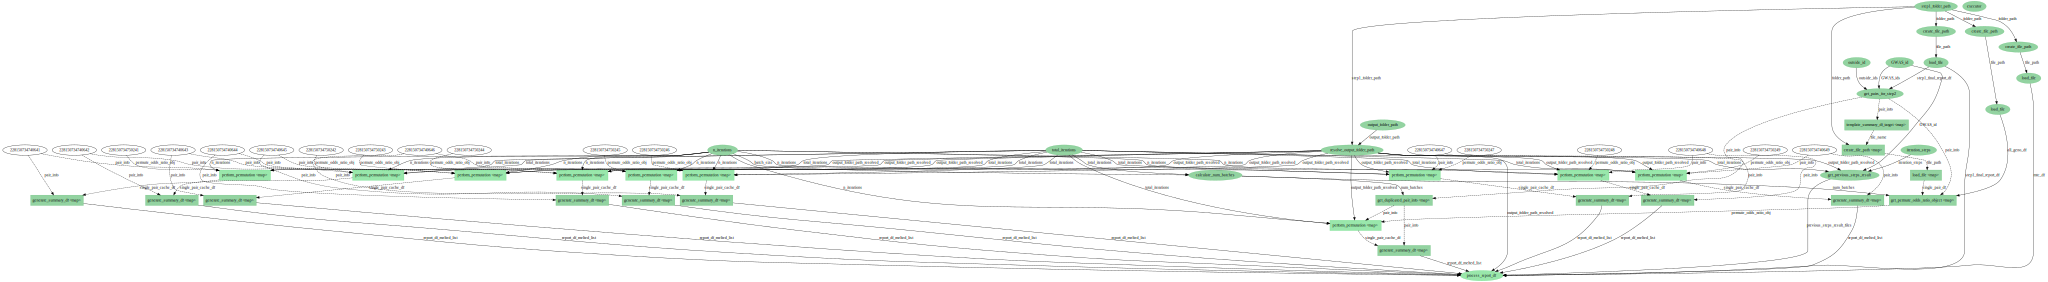

In [116]:

flow_result = dev_flow.run(step1_folder_path = "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/test_prefect/", GWAS_id = "rs134490", n_iterations = 100, total_iterations = 1_000, iteration_steps = [1_000, 10_000, 100_000, 1_000_000, 10_000_000])
dev_flow.visualize(flow_state = flow_result)

In [117]:
flow_result.result[final_report_dfs].result

,GWAS_id,outside_id,GWAS_chrom,outside_chrom,found_in_genetic_file_GWAS,found_in_genetic_file_outside,GWAS_id_geno,outside_id_geno,case_total_no_NA,case_total_with_NA,...,iterations,iter_used_for_pval,num_perm_lower,num_perm_higher,pval,ci_neg,c_i_pos,mtc_threshold,need_more_perm,status
0,rs134490,rs5762201,22,22,1,1,CC,AA,85921.0,86697.0,...,1000,118,828,118,0.118,0.091720,0.144280,0.01,False,non_sig
1,rs134490,rs5762201,22,22,1,1,CC,AG,85921.0,86697.0,...,1000,201,798,201,0.201,0.168355,0.233645,0.01,False,non_sig
2,rs134490,rs5762201,22,22,1,1,CC,GG,85921.0,86697.0,...,1000,169,169,831,0.169,0.138473,0.199527,0.01,False,non_sig
3,rs134490,rs5762201,22,22,1,1,CT,AA,85921.0,86697.0,...,1000,443,443,536,0.443,0.402535,0.483465,0.01,False,non_sig
4,rs134490,rs5762201,22,22,1,1,CT,AG,85921.0,86697.0,...,1000,11,989,11,0.011,0.002503,0.019497,0.01,True,more_perm
5,rs134490,rs5762201,22,22,1,1,CT,GG,85921.0,86697.0,...,1000,11,11,989,0.011,0.002503,0.019497,0.01,True,more_perm
6,rs134490,rs5762201,22,22,1,1,TT,AA,85921.0,86697.0,...,1000,338,660,338,0.338,0.299467,0.376533,0.01,False,non_sig
7,rs134490,rs5762201,22,22,1,1,TT,AG,85921.0,86697.0,...,1000,373,627,373,0.373,0.333606,0.412394,0.01,False,non_sig
8,rs134490,rs5762201,22,22,1,1,TT,GG,85921.0,86697.0,...,1000,654,346,654,0.654,0.615250,0.692750,0.01,False,non_sig


In [118]:
flow_result.result[step1_final_report_df].result.query("GWAS_id == 'rs134490' and outside_id == 'rs5762201'") 

,GWAS_id,outside_id,GWAS_chrom,outside_chrom,found_in_genetic_file_GWAS,found_in_genetic_file_outside,GWAS_id_geno,outside_id_geno,case_total_no_NA,case_total_with_NA,...,control_total_with_NA,odds_ratio_combo,odds_ratio_single,unique_samples_count_case,unique_samples_count_control,all_SNPs_found_in_genetic_file,non_zero_geno_combo_counts,geno_combo_passed_filter_1,pair_has_enough_geno_combo_passed_filter_1,geno_combo_passed_filter_2
44,rs134490,rs5762201,22,22,1,1,CC,AA,85921.0,86697.0,...,253792.0,1.95281,1.01433,6.0,9.0,1,NaN,0,0,0
45,rs134490,rs5762201,22,22,1,1,CC,AG,85921.0,86697.0,...,253792.0,1.09855,1.01433,114.0,304.0,1,NaN,0,0,0
46,rs134490,rs5762201,22,22,1,1,CC,GG,85921.0,86697.0,...,253792.0,1.00445,1.01433,1147.0,3345.0,1,5.0,1,1,1
47,rs134490,rs5762201,22,22,1,1,CT,AA,85921.0,86697.0,...,253792.0,0.97636,1.00263,43.0,129.0,1,NaN,0,0,0
48,rs134490,rs5762201,22,22,1,1,CT,AG,85921.0,86697.0,...,253792.0,1.06638,1.00263,1762.0,4846.0,1,5.0,1,1,1
49,rs134490,rs5762201,22,22,1,1,CT,GG,85921.0,86697.0,...,253792.0,0.99298,1.00263,16136.0,47535.0,1,5.0,1,1,1
50,rs134490,rs5762201,22,22,1,1,TT,AA,85921.0,86697.0,...,253792.0,1.04182,0.99632,170.0,478.0,1,NaN,0,0,0
51,rs134490,rs5762201,22,22,1,1,TT,AG,85921.0,86697.0,...,253792.0,1.00456,0.99632,6285.0,18332.0,1,5.0,1,1,1
52,rs134490,rs5762201,22,22,1,1,TT,GG,85921.0,86697.0,...,253792.0,0.99637,0.99632,60258.0,176694.0,1,5.0,1,1,1


In [119]:
test_data_catalog = test_data_catalog.reload()

In [120]:
test_object = flow_result.result[permute_odds_ratio_objects].result[0][0]
# test_object.reset()
test_object.report_df

,rs134490,rs5762201,odds_ratio_single,odds_ratio_combo,iterations,num_perm_lower,num_perm_higher,num_perm_equal,combo_higher_than_single_binary,combo_higher_than_single_str,iter_used_for_pval,pval
0,CC,AA,1.01433,1.95281,0,0,0,0,1,higher,0,NaN
1,CC,AG,1.01433,1.09855,0,0,0,0,1,higher,0,NaN
2,CC,GG,1.01433,1.00445,0,0,0,0,0,lower,0,NaN
3,CT,AA,1.00263,0.97636,0,0,0,0,0,lower,0,NaN
4,CT,AG,1.00263,1.06638,0,0,0,0,1,higher,0,NaN
5,CT,GG,1.00263,0.99298,0,0,0,0,0,lower,0,NaN
6,TT,AA,0.99632,1.04182,0,0,0,0,1,higher,0,NaN
7,TT,AG,0.99632,1.00456,0,0,0,0,1,higher,0,NaN
8,TT,GG,0.99632,0.99637,0,0,0,0,1,higher,0,NaN


In [121]:
test_object.step1_final_report_df = flow_result.result[step1_final_report_df].result.query("GWAS_id == 'rs134490' and outside_id == 'rs5762201'") 
test_object.step1_final_report_df 

,GWAS_id,outside_id,GWAS_chrom,outside_chrom,found_in_genetic_file_GWAS,found_in_genetic_file_outside,GWAS_id_geno,outside_id_geno,case_total_no_NA,case_total_with_NA,...,control_total_with_NA,odds_ratio_combo,odds_ratio_single,unique_samples_count_case,unique_samples_count_control,all_SNPs_found_in_genetic_file,non_zero_geno_combo_counts,geno_combo_passed_filter_1,pair_has_enough_geno_combo_passed_filter_1,geno_combo_passed_filter_2
44,rs134490,rs5762201,22,22,1,1,CC,AA,85921.0,86697.0,...,253792.0,1.95281,1.01433,6.0,9.0,1,NaN,0,0,0
45,rs134490,rs5762201,22,22,1,1,CC,AG,85921.0,86697.0,...,253792.0,1.09855,1.01433,114.0,304.0,1,NaN,0,0,0
46,rs134490,rs5762201,22,22,1,1,CC,GG,85921.0,86697.0,...,253792.0,1.00445,1.01433,1147.0,3345.0,1,5.0,1,1,1
47,rs134490,rs5762201,22,22,1,1,CT,AA,85921.0,86697.0,...,253792.0,0.97636,1.00263,43.0,129.0,1,NaN,0,0,0
48,rs134490,rs5762201,22,22,1,1,CT,AG,85921.0,86697.0,...,253792.0,1.06638,1.00263,1762.0,4846.0,1,5.0,1,1,1
49,rs134490,rs5762201,22,22,1,1,CT,GG,85921.0,86697.0,...,253792.0,0.99298,1.00263,16136.0,47535.0,1,5.0,1,1,1
50,rs134490,rs5762201,22,22,1,1,TT,AA,85921.0,86697.0,...,253792.0,1.04182,0.99632,170.0,478.0,1,NaN,0,0,0
51,rs134490,rs5762201,22,22,1,1,TT,AG,85921.0,86697.0,...,253792.0,1.00456,0.99632,6285.0,18332.0,1,5.0,1,1,1
52,rs134490,rs5762201,22,22,1,1,TT,GG,85921.0,86697.0,...,253792.0,0.99637,0.99632,60258.0,176694.0,1,5.0,1,1,1


In [122]:
single_pair_df = flow_result.result[single_pair_dfs].result[0]
single_rsid = flow_result.result[pair_info_list].result[0].GWAS_id
all_geno_df_test = flow_result.result[all_geno_df].result
pair_info = flow_result.result[pair_info_list].result[0]


In [123]:
single_pair_df

,rs134490,rs5762201,odds_ratio_combo,odds_ratio_single,unique_samples_id_case,unique_samples_count_case,unique_samples_id_control,unique_samples_count_control,case_total_no_NA,case_total_with_NA,control_total_no_NA,control_total_with_NA
0,CC,AA,1.95281,1.01433,"[1041588, 1042820, 2995054, 4483197, 4522751, ...",6,"[1505529, 1519989, 2019724, 2053028, 3359698, ...",9,85921,86697,251672,253792
1,CC,AG,1.09855,1.01433,"[1078521, 1187600, 1223362, 1247155, 1417959, ...",114,"[1024531, 1064606, 1070868, 1077363, 1079574, ...",304,85921,86697,251672,253792
2,CC,GG,1.00445,1.01433,"[1002197, 1002513, 1010584, 1011406, 1013404, ...",1147,"[1001398, 1001703, 1004740, 1004784, 1007010, ...",3345,85921,86697,251672,253792
3,CT,AA,0.97636,1.00263,"[1186764, 1426246, 1451881, 1723507, 1755428, ...",43,"[1056898, 1065560, 1074468, 1101815, 1103983, ...",129,85921,86697,251672,253792
4,CT,AG,1.06638,1.00263,"[1006888, 1008110, 1010482, 1010781, 1011971, ...",1762,"[1001845, 1003947, 1004277, 1005483, 1007943, ...",4846,85921,86697,251672,253792
5,CT,GG,0.99298,1.00263,"[1000350, 1000505, 1000645, 1001890, 1002317, ...",16136,"[1000258, 1000377, 1000404, 1000496, 1000628, ...",47535,85921,86697,251672,253792
6,TT,AA,1.04182,0.99632,"[1023812, 1063950, 1092872, 1130075, 1135461, ...",170,"[1018820, 1025450, 1034420, 1047213, 1069912, ...",478,85921,86697,251672,253792
7,TT,AG,1.00456,0.99632,"[1000940, 1001562, 1003137, 1003450, 1003767, ...",6285,"[1000194, 1000564, 1000968, 1001106, 1001289, ...",18332,85921,86697,251672,253792
8,TT,GG,0.99637,0.99632,"[1000149, 1000151, 1000173, 1000201, 1000244, ...",60258,"[1000025, 1000038, 1000042, 1000056, 1000061, ...",176694,85921,86697,251672,253792


In [15]:
pair_info

SNPPairInfo(GWAS_id='rs134490', outside_id='rs5762201', GWAS_chrom=22, outside_chrom=22, mtc_threshold=None)

In [16]:
test_permute_odds_object = PermuteOddsRatio(summary_df = single_pair_df, single_rsid=pair_info.GWAS_id, all_geno_df=all_geno_df_test, combo_rsid_list= [pair_info.GWAS_id, pair_info.outside_id], permute_rsid= pair_info.outside_id)
test_permute_odds_object.reset()
test_permute_odds_object.perform_permutation(n_iterations = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


,rs134490,rs5762201,odds_ratio_single,odds_ratio_combo,iterations,num_perm_lower,num_perm_higher,num_perm_equal
0,CC,AA,1.01433,1.95281,100,39,17,0
1,CC,AG,1.01433,1.09855,100,40,11,0
2,CC,GG,1.01433,1.00445,100,41,8,0
3,CT,AA,1.00263,0.97636,100,14,41,0
4,CT,AG,1.00263,1.06638,100,35,17,0
5,CT,GG,1.00263,0.99298,100,12,34,0
6,TT,AA,0.99632,1.04182,100,34,8,0
7,TT,AG,0.99632,1.00456,100,39,10,0
8,TT,GG,0.99632,0.99637,100,14,43,0


In [17]:
#from 07_permutations.ipynb

odds_ratio_df_rs9610458_rs77948203 = test_data_catalog.load("odds_ratio_df_rs9610458_rs77948203")
all_geno_df_rs9610458_rs77948203 = test_data_catalog.load("all_geno_df")
test_permute_odds_object_rs9610458_rs77948203 = PermuteOddsRatio(summary_df = odds_ratio_df_rs9610458_rs77948203,
                    single_rsid= "rs9610458",
                    combo_rsid_list= ["rs9610458", "rs77948203"],
                    all_geno_df = all_geno_df_rs9610458_rs77948203,
                    permute_rsid= "rs77948203")
test_permute_odds_object_rs9610458_rs77948203.perform_permutation(n_iterations = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


,rs9610458,rs77948203,odds_ratio_single,odds_ratio_combo,iterations,num_perm_lower,num_perm_higher,num_perm_equal
0,CC,GG,0.934,0.943,100,71,29,0
1,CC,AG,0.934,0.921,100,34,66,0
2,CC,AA,0.934,0.743,100,29,71,0
3,CT,GG,0.936,0.976,100,98,2,0
4,CT,AG,0.936,0.844,100,2,98,0
5,CT,AA,0.936,0.992,100,40,60,0
6,TT,GG,1.142,1.162,100,95,5,0
7,TT,AG,1.142,1.007,100,15,85,0
8,TT,AA,1.142,0.495,100,6,93,0


---

## Test process_df

In [125]:
def test_process_df(test_flow_result):
    result = process_report_df.run(report_df_melted_list=test_flow_result.result[report_dfs_melted].result,
                  mtc_df = test_flow_result.result[mtc_df].result, 
                  step1_final_report_df=test_flow_result.result[step1_final_report_df].result,
                  output_folder_path_resolved=test_flow_result.result[output_folder_path_resolved].result,
                  previous_steps_result_files=test_flow_result.result[previous_steps_result_files].result)
    return result

In [126]:
flow_result.result[final_report_dfs].result

,GWAS_id,outside_id,GWAS_chrom,outside_chrom,found_in_genetic_file_GWAS,found_in_genetic_file_outside,GWAS_id_geno,outside_id_geno,case_total_no_NA,case_total_with_NA,...,iterations,iter_used_for_pval,num_perm_lower,num_perm_higher,pval,ci_neg,c_i_pos,mtc_threshold,need_more_perm,status
0,rs134490,rs5762201,22,22,1,1,CC,AA,85921.0,86697.0,...,1000,118,828,118,0.118,0.091720,0.144280,0.01,False,non_sig
1,rs134490,rs5762201,22,22,1,1,CC,AG,85921.0,86697.0,...,1000,201,798,201,0.201,0.168355,0.233645,0.01,False,non_sig
2,rs134490,rs5762201,22,22,1,1,CC,GG,85921.0,86697.0,...,1000,169,169,831,0.169,0.138473,0.199527,0.01,False,non_sig
3,rs134490,rs5762201,22,22,1,1,CT,AA,85921.0,86697.0,...,1000,443,443,536,0.443,0.402535,0.483465,0.01,False,non_sig
4,rs134490,rs5762201,22,22,1,1,CT,AG,85921.0,86697.0,...,1000,11,989,11,0.011,0.002503,0.019497,0.01,True,more_perm
5,rs134490,rs5762201,22,22,1,1,CT,GG,85921.0,86697.0,...,1000,11,11,989,0.011,0.002503,0.019497,0.01,True,more_perm
6,rs134490,rs5762201,22,22,1,1,TT,AA,85921.0,86697.0,...,1000,338,660,338,0.338,0.299467,0.376533,0.01,False,non_sig
7,rs134490,rs5762201,22,22,1,1,TT,AG,85921.0,86697.0,...,1000,373,627,373,0.373,0.333606,0.412394,0.01,False,non_sig
8,rs134490,rs5762201,22,22,1,1,TT,GG,85921.0,86697.0,...,1000,654,346,654,0.654,0.615250,0.692750,0.01,False,non_sig


In [127]:
test_process_df(flow_result)

,GWAS_id,outside_id,GWAS_chrom,outside_chrom,found_in_genetic_file_GWAS,found_in_genetic_file_outside,GWAS_id_geno,outside_id_geno,case_total_no_NA,case_total_with_NA,...,iterations,iter_used_for_pval,num_perm_lower,num_perm_higher,pval,ci_neg,c_i_pos,mtc_threshold,need_more_perm,status
0,rs134490,rs5762201,22,22,1,1,CC,AA,85921.0,86697.0,...,1000,118,828,118,0.118,0.091720,0.144280,0.01,False,non_sig
1,rs134490,rs5762201,22,22,1,1,CC,AG,85921.0,86697.0,...,1000,201,798,201,0.201,0.168355,0.233645,0.01,False,non_sig
2,rs134490,rs5762201,22,22,1,1,CC,GG,85921.0,86697.0,...,1000,169,169,831,0.169,0.138473,0.199527,0.01,False,non_sig
3,rs134490,rs5762201,22,22,1,1,CT,AA,85921.0,86697.0,...,1000,443,443,536,0.443,0.402535,0.483465,0.01,False,non_sig
4,rs134490,rs5762201,22,22,1,1,CT,AG,85921.0,86697.0,...,1000,11,989,11,0.011,0.002503,0.019497,0.01,True,more_perm
5,rs134490,rs5762201,22,22,1,1,CT,GG,85921.0,86697.0,...,1000,11,11,989,0.011,0.002503,0.019497,0.01,True,more_perm
6,rs134490,rs5762201,22,22,1,1,TT,AA,85921.0,86697.0,...,1000,338,660,338,0.338,0.299467,0.376533,0.01,False,non_sig
7,rs134490,rs5762201,22,22,1,1,TT,AG,85921.0,86697.0,...,1000,373,627,373,0.373,0.333606,0.412394,0.01,False,non_sig
8,rs134490,rs5762201,22,22,1,1,TT,GG,85921.0,86697.0,...,1000,654,346,654,0.654,0.615250,0.692750,0.01,False,non_sig


In [49]:
determine_if_needs_more_perm.run(flow_result.result[final_report_dfs].result)[1]

,GWAS_id,outside_id,GWAS_chrom,outside_chrom,found_in_genetic_file_GWAS,found_in_genetic_file_outside,GWAS_id_geno,outside_id_geno,case_total_no_NA,case_total_with_NA,...,iterations,iter_used_for_pval,num_perm_lower,num_perm_higher,pval,ci_neg,c_i_pos,mtc_threshold,need_more_perm,status
11,rs134490,rs5762201,22,22,1,1,CT,AG,85921.0,86697.0,...,1000,11,989,11,0.011,0.002503,0.019497,0.01,True,more_perm
12,rs134490,rs5762201,22,22,1,1,CT,GG,85921.0,86697.0,...,1000,11,11,989,0.011,0.002503,0.019497,0.01,True,more_perm


In [16]:
determine_if_needs_more_perm.run(flow_result.result[final_report_dfs].result)

(True,
     GWAS_id outside_id  GWAS_chrom  outside_chrom  found_in_genetic_file_GWAS  \
 4  rs134490  rs5762201          22             22                           1   
 5  rs134490  rs5762201          22             22                           1   
 
    found_in_genetic_file_outside GWAS_id_geno outside_id_geno  \
 4                              1           CT              AG   
 5                              1           CT              GG   
 
    case_total_no_NA  case_total_with_NA  ...  iterations  iter_used_for_pval  \
 4           85921.0             86697.0  ...        1000                  13   
 5           85921.0             86697.0  ...        1000                  18   
 
    num_perm_lower  num_perm_higher   pval    ci_neg   c_i_pos  mtc_threshold  \
 4             987               13  0.013  0.003773  0.022227           0.01   
 5              18              982  0.018  0.007170  0.028830           0.01   
 
    need_more_perm     status  
 4            True  mor

## Test second step

In [128]:
dev_flow.executor = None

In [130]:
flow_result_second_iter_step = dev_flow.run(**dict(step1_folder_path = "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/test_prefect/", GWAS_id = "rs134490", n_iterations = 100, total_iterations = 10_000, iteration_steps = [1_000, 10_000, 100_000, 1_000_000, 10_000_000]))


[2021-12-12 11:52:15-0500] INFO - prefect.FlowRunner | Beginning Flow run for 'OVP_step2'


INFO:prefect.FlowRunner:Beginning Flow run for 'OVP_step2'


[2021-12-12 11:52:15-0500] INFO - prefect.TaskRunner | Task 'total_iterations': Starting task run...


INFO:prefect.TaskRunner:Task 'total_iterations': Starting task run...


[2021-12-12 11:52:15-0500] INFO - prefect.TaskRunner | Task 'total_iterations': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'total_iterations': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:15-0500] INFO - prefect.TaskRunner | Task 'outside_id': Starting task run...


INFO:prefect.TaskRunner:Task 'outside_id': Starting task run...


[2021-12-12 11:52:15-0500] INFO - prefect.TaskRunner | Task 'outside_id': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'outside_id': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'executor': Starting task run...


INFO:prefect.TaskRunner:Task 'executor': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'executor': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'executor': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'step1_folder_path': Starting task run...


INFO:prefect.TaskRunner:Task 'step1_folder_path': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'step1_folder_path': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'step1_folder_path': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'GWAS_id': Starting task run...


INFO:prefect.TaskRunner:Task 'GWAS_id': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'GWAS_id': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'GWAS_id': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'output_folder_path': Starting task run...


INFO:prefect.TaskRunner:Task 'output_folder_path': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'output_folder_path': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'output_folder_path': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'create_file_path': Starting task run...


INFO:prefect.TaskRunner:Task 'create_file_path': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'create_file_path': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'create_file_path': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'iteration_steps': Starting task run...


INFO:prefect.TaskRunner:Task 'iteration_steps': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'iteration_steps': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'iteration_steps': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'n_iterations': Starting task run...


INFO:prefect.TaskRunner:Task 'n_iterations': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'n_iterations': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'n_iterations': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'create_file_path': Starting task run...


INFO:prefect.TaskRunner:Task 'create_file_path': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'create_file_path': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'create_file_path': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'calculate_num_batches': Starting task run...


INFO:prefect.TaskRunner:Task 'calculate_num_batches': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'calculate_num_batches': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'calculate_num_batches': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'resolve_output_folder_path': Starting task run...


INFO:prefect.TaskRunner:Task 'resolve_output_folder_path': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'resolve_output_folder_path': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'resolve_output_folder_path': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'create_file_path': Starting task run...


INFO:prefect.TaskRunner:Task 'create_file_path': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'create_file_path': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'create_file_path': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'load_file': Starting task run...


INFO:prefect.TaskRunner:Task 'load_file': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'load_file': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'load_file': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'load_file': Starting task run...


INFO:prefect.TaskRunner:Task 'load_file': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'load_file': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'load_file': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'load_file': Starting task run...


INFO:prefect.TaskRunner:Task 'load_file': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'load_file': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'load_file': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'get_previous_steps_result': Starting task run...


INFO:prefect.TaskRunner:Task 'get_previous_steps_result': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'get_previous_steps_result': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_previous_steps_result': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'get_pairs_for_step2': Starting task run...


INFO:prefect.TaskRunner:Task 'get_pairs_for_step2': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'get_pairs_for_step2': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_pairs_for_step2': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'template_summary_df_target': Starting task run...


INFO:prefect.TaskRunner:Task 'template_summary_df_target': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'template_summary_df_target': Finished task run for task with final state: 'Mapped'


INFO:prefect.TaskRunner:Task 'template_summary_df_target': Finished task run for task with final state: 'Mapped'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'template_summary_df_target[0]': Starting task run...


INFO:prefect.TaskRunner:Task 'template_summary_df_target[0]': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'template_summary_df_target[0]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'template_summary_df_target[0]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'get_duplicated_pair_info': Starting task run...


INFO:prefect.TaskRunner:Task 'get_duplicated_pair_info': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'get_duplicated_pair_info': Finished task run for task with final state: 'Mapped'


INFO:prefect.TaskRunner:Task 'get_duplicated_pair_info': Finished task run for task with final state: 'Mapped'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'get_duplicated_pair_info[0]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_duplicated_pair_info[0]': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'get_duplicated_pair_info[0]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_duplicated_pair_info[0]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'create_file_path': Starting task run...


INFO:prefect.TaskRunner:Task 'create_file_path': Starting task run...


[2021-12-12 11:52:16-0500] INFO - prefect.TaskRunner | Task 'create_file_path': Finished task run for task with final state: 'Mapped'


INFO:prefect.TaskRunner:Task 'create_file_path': Finished task run for task with final state: 'Mapped'


[2021-12-12 11:52:17-0500] INFO - prefect.TaskRunner | Task 'create_file_path[0]': Starting task run...


INFO:prefect.TaskRunner:Task 'create_file_path[0]': Starting task run...


[2021-12-12 11:52:17-0500] INFO - prefect.TaskRunner | Task 'create_file_path[0]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'create_file_path[0]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:17-0500] INFO - prefect.TaskRunner | Task 'load_file': Starting task run...


INFO:prefect.TaskRunner:Task 'load_file': Starting task run...


[2021-12-12 11:52:17-0500] INFO - prefect.TaskRunner | Task 'load_file': Finished task run for task with final state: 'Mapped'


INFO:prefect.TaskRunner:Task 'load_file': Finished task run for task with final state: 'Mapped'


[2021-12-12 11:52:17-0500] INFO - prefect.TaskRunner | Task 'load_file[0]': Starting task run...


INFO:prefect.TaskRunner:Task 'load_file[0]': Starting task run...


[2021-12-12 11:52:17-0500] INFO - prefect.TaskRunner | Task 'load_file[0]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'load_file[0]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:17-0500] INFO - prefect.TaskRunner | Task 'get_permute_odds_ratio_object': Starting task run...


INFO:prefect.TaskRunner:Task 'get_permute_odds_ratio_object': Starting task run...


[2021-12-12 11:52:17-0500] INFO - prefect.TaskRunner | Task 'get_permute_odds_ratio_object': Finished task run for task with final state: 'Mapped'


INFO:prefect.TaskRunner:Task 'get_permute_odds_ratio_object': Finished task run for task with final state: 'Mapped'


[2021-12-12 11:52:17-0500] INFO - prefect.TaskRunner | Task 'get_permute_odds_ratio_object[0]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_permute_odds_ratio_object[0]': Starting task run...


[2021-12-12 11:52:25-0500] INFO - prefect.TaskRunner | Task 'get_permute_odds_ratio_object[0]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_permute_odds_ratio_object[0]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:25-0500] INFO - prefect.TaskRunner | Task 'perform_permutation': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation': Starting task run...


[2021-12-12 11:52:25-0500] INFO - prefect.TaskRunner | Task 'perform_permutation': Finished task run for task with final state: 'Mapped'


INFO:prefect.TaskRunner:Task 'perform_permutation': Finished task run for task with final state: 'Mapped'


[2021-12-12 11:52:25-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[0]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[0]': Starting task run...


[2021-12-12 11:52:25-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[0]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[0]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:25-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[1]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[1]': Starting task run...


[2021-12-12 11:52:25-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[1]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[1]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:25-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[2]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[2]': Starting task run...


[2021-12-12 11:52:25-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[2]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[2]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:25-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[3]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[3]': Starting task run...


[2021-12-12 11:52:25-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[3]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[3]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:25-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[4]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[4]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[4]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[4]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[5]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[5]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[5]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[5]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[6]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[6]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[6]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[6]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[7]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[7]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[7]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[7]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[8]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[8]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[8]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[8]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[9]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[9]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[9]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[9]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[10]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[10]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[10]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[10]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[11]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[11]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[11]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[11]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[12]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[12]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[12]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[12]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[13]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[13]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[13]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[13]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[14]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[14]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[14]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[14]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[15]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[15]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[15]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[15]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[16]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[16]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[16]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[16]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[17]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[17]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[17]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[17]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[18]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[18]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[18]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[18]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[19]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[19]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[19]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[19]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[20]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[20]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[20]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[20]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[21]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[21]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[21]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[21]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[22]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[22]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[22]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[22]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[23]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[23]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[23]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[23]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[24]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[24]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[24]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[24]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[25]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[25]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[25]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[25]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[26]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[26]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[26]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[26]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[27]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[27]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[27]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[27]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[28]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[28]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[28]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[28]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[29]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[29]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[29]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[29]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[30]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[30]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[30]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[30]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[31]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[31]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[31]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[31]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[32]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[32]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[32]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[32]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[33]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[33]': Starting task run...


[2021-12-12 11:52:26-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[33]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[33]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[34]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[34]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[34]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[34]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[35]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[35]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[35]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[35]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[36]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[36]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[36]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[36]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[37]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[37]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[37]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[37]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[38]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[38]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[38]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[38]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[39]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[39]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[39]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[39]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[40]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[40]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[40]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[40]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[41]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[41]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[41]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[41]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[42]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[42]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[42]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[42]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[43]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[43]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[43]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[43]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[44]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[44]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[44]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[44]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[45]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[45]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[45]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[45]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[46]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[46]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[46]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[46]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[47]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[47]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[47]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[47]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[48]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[48]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[48]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[48]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[49]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[49]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[49]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[49]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[50]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[50]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[50]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[50]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[51]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[51]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[51]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[51]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[52]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[52]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[52]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[52]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[53]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[53]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[53]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[53]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[54]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[54]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[54]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[54]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[55]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[55]': Starting task run...


[2021-12-12 11:52:27-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[55]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[55]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[56]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[56]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[56]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[56]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[57]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[57]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[57]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[57]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[58]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[58]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[58]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[58]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[59]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[59]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[59]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[59]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[60]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[60]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[60]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[60]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[61]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[61]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[61]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[61]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[62]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[62]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[62]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[62]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[63]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[63]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[63]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[63]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[64]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[64]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[64]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[64]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[65]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[65]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[65]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[65]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[66]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[66]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[66]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[66]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[67]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[67]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[67]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[67]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[68]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[68]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[68]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[68]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[69]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[69]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[69]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[69]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[70]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[70]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[70]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[70]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[71]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[71]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[71]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[71]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[72]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[72]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[72]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[72]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[73]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[73]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[73]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[73]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[74]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[74]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[74]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[74]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[75]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[75]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[75]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[75]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[76]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[76]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[76]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[76]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[77]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[77]': Starting task run...


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[77]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[77]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:28-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[78]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[78]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[78]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[78]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[79]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[79]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[79]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[79]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[80]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[80]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[80]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[80]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[81]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[81]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[81]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[81]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[82]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[82]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[82]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[82]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[83]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[83]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[83]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[83]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[84]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[84]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[84]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[84]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[85]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[85]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[85]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[85]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[86]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[86]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[86]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[86]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[87]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[87]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[87]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[87]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[88]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[88]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[88]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[88]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[89]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[89]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[89]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[89]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[90]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[90]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[90]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[90]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[91]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[91]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[91]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[91]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[92]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[92]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[92]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[92]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[93]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[93]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[93]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[93]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[94]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[94]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[94]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[94]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[95]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[95]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[95]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[95]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[96]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[96]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[96]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[96]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[97]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[97]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[97]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[97]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[98]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[98]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[98]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[98]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[99]': Starting task run...


INFO:prefect.TaskRunner:Task 'perform_permutation[99]': Starting task run...


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[99]': Finished task run for task with final state: 'Cached'


INFO:prefect.TaskRunner:Task 'perform_permutation[99]': Finished task run for task with final state: 'Cached'


[2021-12-12 11:52:29-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df': Starting task run...


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df': Finished task run for task with final state: 'Mapped'


INFO:prefect.TaskRunner:Task 'generate_summary_df': Finished task run for task with final state: 'Mapped'


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[0]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[0]': Starting task run...


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[0]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[0]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[1]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[1]': Starting task run...


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[1]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[1]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[2]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[2]': Starting task run...


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[2]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[2]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[3]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[3]': Starting task run...


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[3]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[3]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[4]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[4]': Starting task run...


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[4]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[4]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[5]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[5]': Starting task run...


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[5]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[5]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[6]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[6]': Starting task run...


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[6]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[6]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[7]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[7]': Starting task run...


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[7]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[7]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[8]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[8]': Starting task run...


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[8]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[8]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[9]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[9]': Starting task run...


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[9]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[9]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[10]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[10]': Starting task run...


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[10]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[10]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[11]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[11]': Starting task run...


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[11]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[11]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[12]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[12]': Starting task run...


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[12]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[12]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[13]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[13]': Starting task run...


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[13]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[13]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[14]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[14]': Starting task run...


[2021-12-12 11:52:30-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[14]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[14]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[15]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[15]': Starting task run...


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[15]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[15]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[16]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[16]': Starting task run...


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[16]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[16]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[17]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[17]': Starting task run...


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[17]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[17]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[18]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[18]': Starting task run...


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[18]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[18]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[19]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[19]': Starting task run...


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[19]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[19]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[20]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[20]': Starting task run...


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[20]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[20]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[21]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[21]': Starting task run...


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[21]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[21]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[22]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[22]': Starting task run...


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[22]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[22]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[23]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[23]': Starting task run...


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[23]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[23]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[24]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[24]': Starting task run...


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[24]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[24]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[25]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[25]': Starting task run...


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[25]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[25]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[26]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[26]': Starting task run...


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[26]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[26]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[27]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[27]': Starting task run...


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[27]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[27]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[28]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[28]': Starting task run...


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[28]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[28]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[29]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[29]': Starting task run...


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[29]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[29]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:31-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[30]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[30]': Starting task run...


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[30]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[30]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[31]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[31]': Starting task run...


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[31]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[31]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[32]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[32]': Starting task run...


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[32]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[32]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[33]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[33]': Starting task run...


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[33]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[33]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[34]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[34]': Starting task run...


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[34]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[34]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[35]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[35]': Starting task run...


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[35]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[35]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[36]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[36]': Starting task run...


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[36]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[36]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[37]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[37]': Starting task run...


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[37]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[37]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[38]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[38]': Starting task run...


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[38]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[38]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[39]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[39]': Starting task run...


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[39]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[39]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[40]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[40]': Starting task run...


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[40]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[40]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[41]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[41]': Starting task run...


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[41]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[41]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[42]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[42]': Starting task run...


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[42]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[42]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[43]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[43]': Starting task run...


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[43]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[43]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:32-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[44]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[44]': Starting task run...


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[44]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[44]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[45]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[45]': Starting task run...


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[45]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[45]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[46]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[46]': Starting task run...


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[46]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[46]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[47]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[47]': Starting task run...


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[47]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[47]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[48]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[48]': Starting task run...


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[48]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[48]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[49]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[49]': Starting task run...


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[49]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[49]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[50]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[50]': Starting task run...


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[50]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[50]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[51]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[51]': Starting task run...


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[51]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[51]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[52]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[52]': Starting task run...


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[52]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[52]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[53]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[53]': Starting task run...


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[53]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[53]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[54]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[54]': Starting task run...


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[54]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[54]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[55]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[55]': Starting task run...


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[55]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[55]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[56]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[56]': Starting task run...


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[56]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[56]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[57]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[57]': Starting task run...


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[57]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[57]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[58]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[58]': Starting task run...


[2021-12-12 11:52:33-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[58]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[58]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[59]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[59]': Starting task run...


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[59]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[59]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[60]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[60]': Starting task run...


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[60]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[60]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[61]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[61]': Starting task run...


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[61]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[61]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[62]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[62]': Starting task run...


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[62]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[62]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[63]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[63]': Starting task run...


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[63]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[63]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[64]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[64]': Starting task run...


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[64]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[64]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[65]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[65]': Starting task run...


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[65]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[65]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[66]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[66]': Starting task run...


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[66]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[66]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[67]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[67]': Starting task run...


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[67]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[67]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[68]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[68]': Starting task run...


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[68]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[68]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[69]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[69]': Starting task run...


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[69]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[69]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[70]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[70]': Starting task run...


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[70]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[70]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[71]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[71]': Starting task run...


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[71]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[71]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[72]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[72]': Starting task run...


[2021-12-12 11:52:34-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[72]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[72]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[73]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[73]': Starting task run...


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[73]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[73]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[74]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[74]': Starting task run...


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[74]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[74]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[75]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[75]': Starting task run...


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[75]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[75]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[76]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[76]': Starting task run...


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[76]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[76]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[77]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[77]': Starting task run...


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[77]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[77]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[78]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[78]': Starting task run...


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[78]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[78]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[79]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[79]': Starting task run...


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[79]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[79]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[80]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[80]': Starting task run...


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[80]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[80]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[81]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[81]': Starting task run...


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[81]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[81]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[82]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[82]': Starting task run...


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[82]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[82]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[83]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[83]': Starting task run...


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[83]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[83]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[84]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[84]': Starting task run...


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[84]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[84]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[85]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[85]': Starting task run...


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[85]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[85]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[86]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[86]': Starting task run...


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[86]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[86]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[87]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[87]': Starting task run...


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[87]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[87]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:35-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[88]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[88]': Starting task run...


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[88]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[88]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[89]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[89]': Starting task run...


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[89]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[89]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[90]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[90]': Starting task run...


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[90]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[90]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[91]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[91]': Starting task run...


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[91]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[91]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[92]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[92]': Starting task run...


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[92]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[92]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[93]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[93]': Starting task run...


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[93]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[93]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[94]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[94]': Starting task run...


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[94]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[94]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[95]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[95]': Starting task run...


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[95]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[95]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[96]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[96]': Starting task run...


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[96]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[96]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[97]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[97]': Starting task run...


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[97]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[97]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[98]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[98]': Starting task run...


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[98]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[98]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[99]': Starting task run...


INFO:prefect.TaskRunner:Task 'generate_summary_df[99]': Starting task run...


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[99]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'generate_summary_df[99]': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'process_report_df': Starting task run...


INFO:prefect.TaskRunner:Task 'process_report_df': Starting task run...


[2021-12-12 11:52:36-0500] INFO - prefect.TaskRunner | Task 'process_report_df': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'process_report_df': Finished task run for task with final state: 'Success'


[2021-12-12 11:52:36-0500] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


INFO:prefect.FlowRunner:Flow run SUCCESS: all reference tasks succeeded


In [131]:
flow_result_second_iter_step.result

{<Task: load_file>: <Success: "Task run succeeded.">,
 <Parameter: total_iterations>: <Success: "Task run succeeded.">,
 <Task: get_previous_steps_result>: <Success: "Task run succeeded.">,
 <Task: create_file_path>: <Success: "Task run succeeded.">,
 <Task: template_summary_df_target>: <Mapped: "Ready to proceed with mapping.">,
 <Task: calculate_num_batches>: <Success: "Task run succeeded.">,
 <Task: get_duplicated_pair_info>: <Mapped: "Ready to proceed with mapping.">,
 <Task: resolve_output_folder_path>: <Success: "Task run succeeded.">,
 <Task: create_file_path>: <Success: "Task run succeeded.">,
 <Parameter: outside_id>: <Success: "Task run succeeded.">,
 <Task: create_file_path>: <Mapped: "Ready to proceed with mapping.">,
 <Task: load_file>: <Mapped: "Ready to proceed with mapping.">,
 <Task: perform_permutation>: <Mapped: "Ready to proceed with mapping.">,
 <Task: process_report_df>: <Success: "Task run succeeded.">,
 <Task: get_pairs_for_step2>: <Success: "Task run succeeded.

In [132]:
dev_flow.visualize(flow_state = flow_result_second_iter_step)

In [133]:
flow_result_second_iter_step.result[final_report_dfs].result

,GWAS_id,outside_id,GWAS_chrom,outside_chrom,found_in_genetic_file_GWAS,found_in_genetic_file_outside,GWAS_id_geno,outside_id_geno,case_total_no_NA,case_total_with_NA,...,iterations,iter_used_for_pval,num_perm_lower,num_perm_higher,pval,ci_neg,c_i_pos,mtc_threshold,need_more_perm,status
0,rs134490,rs5762201,22,22,1,1,CC,AA,85921.0,86697.0,...,11000,1321,9128,1321,0.120091,0.112107,0.128075,0.01,False,non_sig
1,rs134490,rs5762201,22,22,1,1,CC,AG,85921.0,86697.0,...,11000,2262,8725,2262,0.205636,0.195710,0.215563,0.01,False,non_sig
2,rs134490,rs5762201,22,22,1,1,CC,GG,85921.0,86697.0,...,11000,1847,1847,9148,0.167909,0.158728,0.177090,0.01,False,non_sig
3,rs134490,rs5762201,22,22,1,1,CT,AA,85921.0,86697.0,...,11000,4805,4805,6013,0.436818,0.424636,0.449000,0.01,False,non_sig
4,rs134490,rs5762201,22,22,1,1,CT,AG,85921.0,86697.0,...,11000,122,10878,122,0.011091,0.008519,0.013663,0.01,True,more_perm
5,rs134490,rs5762201,22,22,1,1,CT,GG,85921.0,86697.0,...,11000,131,131,10869,0.011909,0.009245,0.014573,0.01,True,more_perm
6,rs134490,rs5762201,22,22,1,1,TT,AA,85921.0,86697.0,...,11000,3506,7480,3506,0.318727,0.307282,0.330172,0.01,False,non_sig
7,rs134490,rs5762201,22,22,1,1,TT,AG,85921.0,86697.0,...,11000,4034,6965,4034,0.366727,0.354891,0.378564,0.01,False,non_sig
8,rs134490,rs5762201,22,22,1,1,TT,GG,85921.0,86697.0,...,11000,7260,3734,7260,0.660000,0.648365,0.671635,0.01,False,non_sig


In [134]:
test_genotype_query = "GWAS_id_geno == 'CT' and outside_id_geno == 'AA'"
one_genotype = pd.concat(flow_result_second_iter_step.result[report_dfs_melted].result).query(test_genotype_query)
assert one_genotype["iterations"].sum() == 10_000

In [139]:
assert pd.concat(flow_result_second_iter_step.result[previous_steps_result_files].result).query(test_genotype_query)["iterations"].sum() == 1_000

In [140]:
test_process_df(flow_result_second_iter_step)

,GWAS_id,outside_id,GWAS_chrom,outside_chrom,found_in_genetic_file_GWAS,found_in_genetic_file_outside,GWAS_id_geno,outside_id_geno,case_total_no_NA,case_total_with_NA,...,iterations,iter_used_for_pval,num_perm_lower,num_perm_higher,pval,ci_neg,c_i_pos,mtc_threshold,need_more_perm,status
0,rs134490,rs5762201,22,22,1,1,CC,AA,85921.0,86697.0,...,11000,1321,9128,1321,0.120091,0.112107,0.128075,0.01,False,non_sig
1,rs134490,rs5762201,22,22,1,1,CC,AG,85921.0,86697.0,...,11000,2262,8725,2262,0.205636,0.195710,0.215563,0.01,False,non_sig
2,rs134490,rs5762201,22,22,1,1,CC,GG,85921.0,86697.0,...,11000,1847,1847,9148,0.167909,0.158728,0.177090,0.01,False,non_sig
3,rs134490,rs5762201,22,22,1,1,CT,AA,85921.0,86697.0,...,11000,4805,4805,6013,0.436818,0.424636,0.449000,0.01,False,non_sig
4,rs134490,rs5762201,22,22,1,1,CT,AG,85921.0,86697.0,...,11000,122,10878,122,0.011091,0.008519,0.013663,0.01,True,more_perm
5,rs134490,rs5762201,22,22,1,1,CT,GG,85921.0,86697.0,...,11000,131,131,10869,0.011909,0.009245,0.014573,0.01,True,more_perm
6,rs134490,rs5762201,22,22,1,1,TT,AA,85921.0,86697.0,...,11000,3506,7480,3506,0.318727,0.307282,0.330172,0.01,False,non_sig
7,rs134490,rs5762201,22,22,1,1,TT,AG,85921.0,86697.0,...,11000,4034,6965,4034,0.366727,0.354891,0.378564,0.01,False,non_sig
8,rs134490,rs5762201,22,22,1,1,TT,GG,85921.0,86697.0,...,11000,7260,3734,7260,0.660000,0.648365,0.671635,0.01,False,non_sig


In [145]:
determine_if_needs_more_perm.run(flow_result_second_iter_step.result[final_report_dfs].result)[1]

,GWAS_id,outside_id,GWAS_chrom,outside_chrom,found_in_genetic_file_GWAS,found_in_genetic_file_outside,GWAS_id_geno,outside_id_geno,case_total_no_NA,case_total_with_NA,...,iterations,iter_used_for_pval,num_perm_lower,num_perm_higher,pval,ci_neg,c_i_pos,mtc_threshold,need_more_perm,status
4,rs134490,rs5762201,22,22,1,1,CT,AG,85921.0,86697.0,...,11000,122,10878,122,0.011091,0.008519,0.013663,0.01,True,more_perm
5,rs134490,rs5762201,22,22,1,1,CT,GG,85921.0,86697.0,...,11000,131,131,10869,0.011909,0.009245,0.014573,0.01,True,more_perm


In [41]:
#run with smaller batches 100 instead of 1000, need to delete rs134490_10000_total_iterations file
flow_result_smaller_batch = dev_flow.run(**dict(step1_folder_path = "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/test_prefect/", GWAS_id = "rs134490", n_iterations = 500, total_iterations = 10_000, iteration_steps = [1_000, 10_000, 100_000, 1_000_000, 10_000_000]))

[2021-12-03 10:11:27-0500] INFO - prefect.FlowRunner | Beginning Flow run for 'OVP_step2'
[2021-12-03 10:11:27-0500] INFO - prefect.DaskExecutor | Connecting to an existing Dask cluster at tcp://172.18.102.9:8789


KeyboardInterrupt: 

In [40]:
flow_result_smaller_batch.result[report_dfs_melted].result

[    GWAS_id GWAS_id_geno outside_id outside_id_geno  \
 0  rs134490           CC  rs5762201              AA   
 1  rs134490           CC  rs5762201              AG   
 2  rs134490           CC  rs5762201              GG   
 3  rs134490           CT  rs5762201              AA   
 4  rs134490           CT  rs5762201              AG   
 5  rs134490           CT  rs5762201              GG   
 6  rs134490           TT  rs5762201              AA   
 7  rs134490           TT  rs5762201              AG   
 8  rs134490           TT  rs5762201              GG   
 
    combo_higher_than_single_binary combo_higher_than_single_str  \
 0                                1                       higher   
 1                                1                       higher   
 2                                0                        lower   
 3                                0                        lower   
 4                                1                       higher   
 5                            

In [38]:
#using 100 batch
flow_result_smaller_batch.result[report_dfs_melted].result

[    GWAS_id GWAS_id_geno outside_id outside_id_geno  \
 0  rs134490           CC  rs5762201              AA   
 1  rs134490           CC  rs5762201              AG   
 2  rs134490           CC  rs5762201              GG   
 3  rs134490           CT  rs5762201              AA   
 4  rs134490           CT  rs5762201              AG   
 5  rs134490           CT  rs5762201              GG   
 6  rs134490           TT  rs5762201              AA   
 7  rs134490           TT  rs5762201              AG   
 8  rs134490           TT  rs5762201              GG   
 
    combo_higher_than_single_binary combo_higher_than_single_str  \
 0                                1                       higher   
 1                                1                       higher   
 2                                0                        lower   
 3                                0                        lower   
 4                                1                       higher   
 5                            

In [37]:
pd.concat(flow_result_smaller_batch.result[report_dfs_melted].result).groupby(["GWAS_id", "GWAS_id_geno", "outside_id", "outside_id_geno", "combo_higher_than_single_str"]).\
agg({"iterations": "sum",
                "iter_used_for_pval": "sum",
                 "num_perm_lower":"sum",
                 "num_perm_higher":"sum",
                }).reset_index()

,GWAS_id,GWAS_id_geno,outside_id,outside_id_geno,combo_higher_than_single_str,iterations,iter_used_for_pval,num_perm_lower,num_perm_higher
0,rs134490,CC,rs5762201,AA,higher,10000,1206,3939,1206
1,rs134490,CC,rs5762201,AG,higher,10000,1230,3909,1230
2,rs134490,CC,rs5762201,GG,lower,10000,3893,3893,1171
3,rs134490,CT,rs5762201,AA,lower,10000,1200,1200,3880
4,rs134490,CT,rs5762201,AG,higher,10000,1231,3785,1231
5,rs134490,CT,rs5762201,GG,lower,10000,1240,1240,3858
6,rs134490,TT,rs5762201,AA,higher,10000,1210,3876,1210
7,rs134490,TT,rs5762201,AG,higher,10000,1169,3903,1169
8,rs134490,TT,rs5762201,GG,higher,10000,3937,1150,3937


In [35]:
flow_result_smaller_batch.result[previous_steps_result_files].result[0]

,GWAS_id,outside_id,GWAS_chrom,outside_chrom,found_in_genetic_file_GWAS,found_in_genetic_file_outside,GWAS_id_geno,outside_id_geno,case_total_no_NA,case_total_with_NA,...,iterations,iter_used_for_pval,num_perm_lower,num_perm_higher,pval,ci_neg,c_i_pos,mtc_threshold,need_more_perm,status
0,rs134490,rs5762201,22,22,1,1,CC,AA,85921.0,86697.0,...,1000,138,813,138,0.138,0.109904,0.166096,0.01,False,non_sig
1,rs134490,rs5762201,22,22,1,1,CC,AG,85921.0,86697.0,...,1000,197,803,197,0.197,0.164601,0.229399,0.01,False,non_sig
2,rs134490,rs5762201,22,22,1,1,CC,GG,85921.0,86697.0,...,1000,170,170,830,0.170,0.139401,0.200599,0.01,False,non_sig
3,rs134490,rs5762201,22,22,1,1,CT,AA,85921.0,86697.0,...,1000,434,434,545,0.434,0.393626,0.474374,0.01,False,non_sig
4,rs134490,rs5762201,22,22,1,1,CT,AG,85921.0,86697.0,...,1000,13,987,13,0.013,0.003773,0.022227,0.01,True,more_perm
5,rs134490,rs5762201,22,22,1,1,CT,GG,85921.0,86697.0,...,1000,18,18,982,0.018,0.007170,0.028830,0.01,True,more_perm
6,rs134490,rs5762201,22,22,1,1,TT,AA,85921.0,86697.0,...,1000,343,657,343,0.343,0.304330,0.381670,0.01,False,non_sig
7,rs134490,rs5762201,22,22,1,1,TT,AG,85921.0,86697.0,...,1000,372,628,372,0.372,0.332627,0.411373,0.01,False,non_sig
8,rs134490,rs5762201,22,22,1,1,TT,GG,85921.0,86697.0,...,1000,667,333,667,0.667,0.628609,0.705391,0.01,False,non_sig


In [30]:
flow_result_smaller_batch.result[final_report_dfs].result

,GWAS_id,outside_id,GWAS_chrom,outside_chrom,found_in_genetic_file_GWAS,found_in_genetic_file_outside,GWAS_id_geno,outside_id_geno,case_total_no_NA,case_total_with_NA,...,iterations,iter_used_for_pval,num_perm_lower,num_perm_higher,pval,ci_neg,c_i_pos,mtc_threshold,need_more_perm,status
0,rs134490,rs5762201,22,22,1,1,CC,AA,85921.0,86697.0,...,11000,1344,4752,1344,0.122182,0.114138,0.130226,0.01,False,non_sig
1,rs134490,rs5762201,22,22,1,1,CC,AG,85921.0,86697.0,...,11000,1427,4712,1427,0.129727,0.121475,0.137980,0.01,False,non_sig
2,rs134490,rs5762201,22,22,1,1,CC,GG,85921.0,86697.0,...,11000,4063,4063,2001,0.369364,0.357510,0.381218,0.01,False,non_sig
3,rs134490,rs5762201,22,22,1,1,CT,AA,85921.0,86697.0,...,11000,1634,1634,4425,0.148545,0.139811,0.157280,0.01,False,non_sig
4,rs134490,rs5762201,22,22,1,1,CT,AG,85921.0,86697.0,...,11000,1244,4772,1244,0.113091,0.105312,0.120870,0.01,False,non_sig
5,rs134490,rs5762201,22,22,1,1,CT,GG,85921.0,86697.0,...,11000,1258,1258,4840,0.114364,0.106547,0.122180,0.01,False,non_sig
6,rs134490,rs5762201,22,22,1,1,TT,AA,85921.0,86697.0,...,11000,1553,4533,1553,0.141182,0.132629,0.149734,0.01,False,non_sig
7,rs134490,rs5762201,22,22,1,1,TT,AG,85921.0,86697.0,...,11000,1541,4531,1541,0.140091,0.131566,0.148616,0.01,False,non_sig
8,rs134490,rs5762201,22,22,1,1,TT,GG,85921.0,86697.0,...,11000,4604,1483,4604,0.418545,0.406429,0.430662,0.01,False,non_sig


In [28]:
determine_if_needs_more_perm.run(flow_result_smaller_batch.result[final_report_dfs].result)[0]

False

---

In [ ]:
['GWAS_id', 'GWAS_id_geno', 'outside_id', 'outside_id_geno',
       'combo_higher_than_single_binary', 'combo_higher_than_single_str',
       'odds_ratio_combo', 'odds_ratio_single', 'pval']

In [ ]:
[["GWAS_id", "GWAS_id_geno", "outside_id", "outside_id_geno", 'GWAS_chrom', 'all_SNPs_found_in_genetic_file', 'case_total_no_NA',
       'case_total_with_NA', 'combo_higher_than_single_binary',  "combo_higher_than_single_str",
       'control_total_no_NA', 'control_total_with_NA',
       'found_in_genetic_file_GWAS', 'found_in_genetic_file_outside',
       'geno_combo_passed_filter_1', 'geno_combo_passed_filter_2',
    'odds_ratio_combo', 'odds_ratio_single',
       'outside_chrom', 'pair_has_enough_geno_combo_passed_filter_1',
       'unique_samples_count_case', 'unique_samples_count_control']]

In [ ]:
[["GWAS_id", "GWAS_id_geno", "outside_id", "outside_id_geno", 'GWAS_chrom', 'all_SNPs_found_in_genetic_file', 'case_total_no_NA',
       'case_total_with_NA', 'combo_higher_than_single_binary',  "combo_higher_than_single_str",
       'control_total_no_NA', 'control_total_with_NA',
       'found_in_genetic_file_GWAS', 'found_in_genetic_file_outside',
       'geno_combo_passed_filter_1', 'geno_combo_passed_filter_2',
       'non_zero_geno_combo_counts', 'odds_ratio_combo', 'odds_ratio_single',
       'outside_chrom', 'pair_has_enough_geno_combo_passed_filter_1',
       'unique_samples_count_case', 'unique_samples_count_control']]

[2021-11-19 14:49:59-0500] INFO - prefect.FlowRunner | Beginning Flow run for 'OVP_step2'
[2021-11-19 14:49:59-0500] INFO - prefect.TaskRunner | Task 'outside_id': Starting task run...
[2021-11-19 14:49:59-0500] INFO - prefect.TaskRunner | Task 'outside_id': Finished task run for task with final state: 'Success'
[2021-11-19 14:49:59-0500] INFO - prefect.TaskRunner | Task 'step1_folder_path': Starting task run...
[2021-11-19 14:49:59-0500] INFO - prefect.TaskRunner | Task 'step1_folder_path': Finished task run for task with final state: 'Success'
[2021-11-19 14:49:59-0500] INFO - prefect.TaskRunner | Task 'GWAS_id': Starting task run...
[2021-11-19 14:49:59-0500] INFO - prefect.TaskRunner | Task 'GWAS_id': Finished task run for task with final state: 'Success'
[2021-11-19 14:49:59-0500] INFO - prefect.TaskRunner | Task 'executor': Starting task run...
[2021-11-19 14:49:59-0500] INFO - prefect.TaskRunner | Task 'executor': Finished task run for task with final state: 'Success'
[2021-11-1

  0%|          | 0/10 [00:00<?, ?it/s]

[2021-11-19 14:50:05-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[0]': Finished task run for task with final state: 'Success'
[2021-11-19 14:50:05-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[1]': Starting task run...


  0%|          | 0/10 [00:00<?, ?it/s]

[2021-11-19 14:50:09-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[1]': Finished task run for task with final state: 'Success'
[2021-11-19 14:50:09-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[2]': Starting task run...


  0%|          | 0/10 [00:00<?, ?it/s]

[2021-11-19 14:50:11-0500] INFO - prefect.TaskRunner | Task 'perform_permutation[2]': Finished task run for task with final state: 'Success'
[2021-11-19 14:50:11-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df': Starting task run...
[2021-11-19 14:50:11-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df': Finished task run for task with final state: 'Mapped'
[2021-11-19 14:50:11-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[0]': Starting task run...
[2021-11-19 14:50:12-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[0]': Finished task run for task with final state: 'Success'
[2021-11-19 14:50:12-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[1]': Starting task run...
[2021-11-19 14:50:12-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[1]': Finished task run for task with final state: 'Success'
[2021-11-19 14:50:12-0500] INFO - prefect.TaskRunner | Task 'generate_summary_df[2]': Starting task run...
[2021-11-19 14:

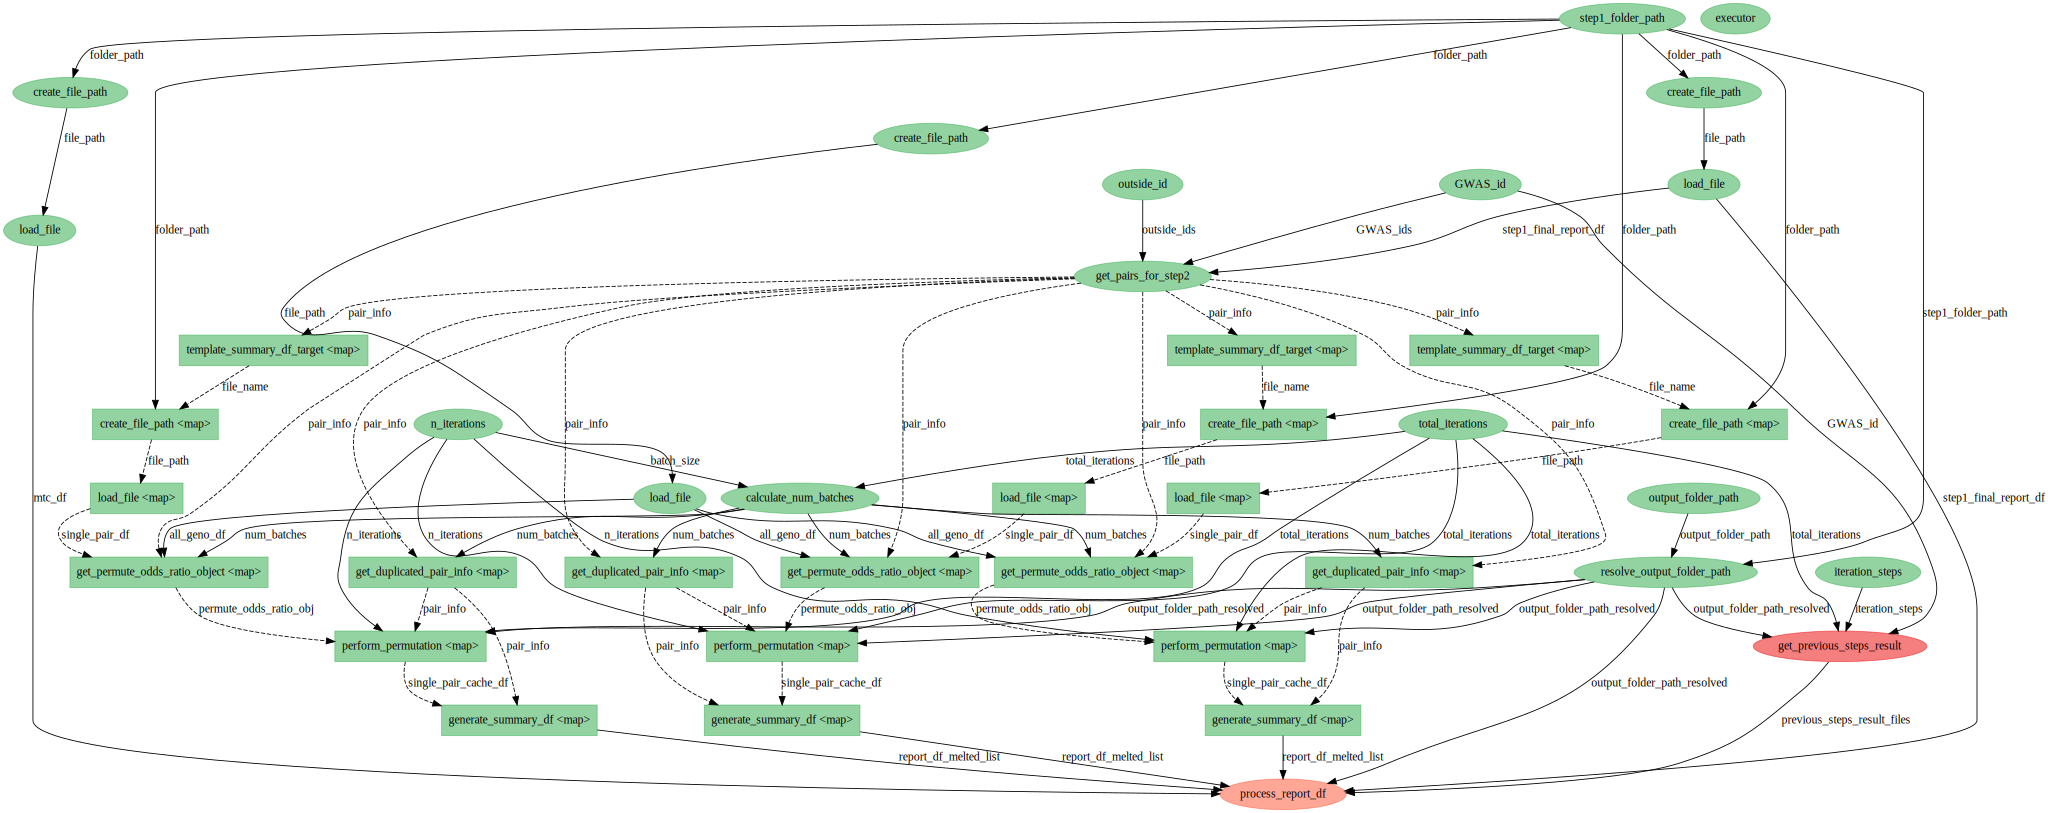

In [189]:
#if n_iterations = 100 > total_iterations = 10, only perform 10 iter
failed_flow_result = dev_flow.run(step1_folder_path = "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/test_prefect/",
                                  n_iterations = 100,
                                  total_iterations = 1_0)
dev_flow.visualize(flow_state = failed_flow_result)


In [90]:
flow_result.result

{<Task: load_file>: <Success: "Task run succeeded.">,
 <Task: get_pairs_for_step2>: <Success: "Task run succeeded.">,
 <Task: create_file_path>: <Mapped: "Ready to proceed with mapping.">,
 <Task: get_duplicated_pair_info>: <Mapped: "Ready to proceed with mapping.">,
 <Task: create_file_path>: <Success: "Task run succeeded.">,
 <Task: create_file_path>: <Success: "Task run succeeded.">,
 <Task: resolve_output_folder_path>: <Success: "Task run succeeded.">,
 <Task: get_permute_odds_ratio_object>: <Mapped: "Ready to proceed with mapping.">,
 <Parameter: n_iterations>: <Success: "Task run succeeded.">,
 <Task: perform_permutation>: <Mapped: "Ready to proceed with mapping.">,
 <Task: create_file_path>: <Success: "Task run succeeded.">,
 <Task: load_file>: <Success: "Task run succeeded.">,
 <Task: load_file>: <Mapped: "Ready to proceed with mapping.">,
 <Parameter: total_iterations>: <Success: "Task run succeeded.">,
 <Parameter: executor>: <Success: "Task run succeeded.">,
 <Parameter: out

In [260]:
pd.concat(flow_result.result[report_dfs_melted].result)

,GWAS_id,GWAS_id_geno,outside_id,outside_id_geno,combo_higher_than_single_binary,combo_higher_than_single_str,iter_used_for_pval,iterations,num_perm_higher,num_perm_lower,odds_ratio_combo,odds_ratio_single,pval
0,rs134490,CC,rs5762201,AA,1,higher,2,10,2,8,1.95281,1.01433,0.2
1,rs134490,CC,rs5762201,AG,1,higher,1,10,1,9,1.09855,1.01433,0.1
2,rs134490,CC,rs5762201,GG,0,lower,1,10,9,1,1.00445,1.01433,0.1
3,rs134490,CT,rs5762201,AA,0,lower,5,10,5,5,0.97636,1.00263,0.5
4,rs134490,CT,rs5762201,AG,1,higher,0,10,0,10,1.06638,1.00263,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,rs9610458,CT,rs77948203,AG,0,lower,3,10,7,3,0.99269,1.00076,0.3
5,rs9610458,CT,rs77948203,AA,1,higher,4,10,4,6,1.00748,1.00076,0.4
6,rs9610458,TT,rs77948203,GG,0,lower,2,10,8,2,0.98417,0.98439,0.2
7,rs9610458,TT,rs77948203,AG,1,higher,2,10,2,8,0.99814,0.98439,0.2


In [261]:
flow_result.result[final_report_dfs].result

,GWAS_id,outside_id,GWAS_chrom,outside_chrom,found_in_genetic_file_GWAS,found_in_genetic_file_outside,GWAS_id_geno,outside_id_geno,case_total_no_NA,case_total_with_NA,...,iter_used_for_pval,iterations,num_perm_higher,num_perm_lower,pval,ci_neg,c_i_pos,mtc_threshold,need_more_perm,status
0,rs134490,rs5762201,NaN,NaN,NaN,NaN,CC,AA,NaN,NaN,...,0,1000,0,0,0.001,-0.001575,0.003575,0.01,False,sig_lower
1,rs134490,rs5762201,NaN,NaN,NaN,NaN,CC,AG,NaN,NaN,...,43,1000,319,43,0.043,0.026475,0.059525,0.01,False,non_sig
2,rs134490,rs5762201,NaN,NaN,NaN,NaN,CC,GG,NaN,NaN,...,57,1000,57,303,0.057,0.038114,0.075886,0.01,False,non_sig
3,rs134490,rs5762201,NaN,NaN,NaN,NaN,CT,AA,NaN,NaN,...,2,1000,329,2,0.002,-0.001639,0.005639,0.01,False,sig_lower
4,rs134490,rs5762201,NaN,NaN,NaN,NaN,CT,AG,NaN,NaN,...,148,1000,463,148,0.148,0.119073,0.176927,0.01,False,non_sig
5,rs134490,rs5762201,NaN,NaN,NaN,NaN,CT,GG,NaN,NaN,...,406,1000,406,170,0.406,0.365996,0.446004,0.01,False,non_sig
6,rs134490,rs5762201,NaN,NaN,NaN,NaN,TT,AA,NaN,NaN,...,48,1000,242,48,0.048,0.030587,0.065413,0.01,False,non_sig
7,rs134490,rs5762201,NaN,NaN,NaN,NaN,TT,AG,NaN,NaN,...,151,1000,473,151,0.151,0.121833,0.180167,0.01,False,non_sig
8,rs134490,rs5762201,NaN,NaN,NaN,NaN,TT,GG,NaN,NaN,...,433,1000,163,433,0.433,0.392637,0.473363,0.01,False,non_sig


In [199]:
process_report_df.run(flow_result.result[report_dfs_melted].result, mtc_df = flow_result.result[mtc_df].result, step1_final_report_df= flow_result.result[step1_final_report_df].result)

TypeError: process_report_df() missing 2 required positional arguments: 'output_folder_path_resolved' and 'previous_steps_result_files'

In [81]:
get_permute_odds_ratio_object.run(single_pair_df,pair_info, all_geno_df, 100_000)

In [217]:
pd.concat(list(flow_result.result.items())[-2][1].result).query("status == 'more_perm'")#[["all_SNPs_found_in_genetic_file","status", "geno_combo_passed_filter_2"]].query("all_SNPs_found_in_genetic_file == 0")

,GWAS_id,GWAS_id_geno,outside_id,outside_id_geno,combo_higher_than_single_binary,combo_higher_than_single_str,iter_used_for_pval,iterations,num_perm_higher,num_perm_lower,...,case_total_with_NA,control_total_no_NA,control_total_with_NA,unique_samples_count_case,unique_samples_count_control,all_SNPs_found_in_genetic_file,non_zero_geno_combo_counts,geno_combo_passed_filter_1,pair_has_enough_geno_combo_passed_filter_1,geno_combo_passed_filter_2
0,rs134490,CC,rs5762201,AA,0,lower,0,100,0,0,...,9772.0,4496.0,5175.0,NaN,NaN,1,NaN,0,0,0
1,rs134490,CC,rs5762201,AG,0,lower,6,100,36,6,...,9772.0,4496.0,5175.0,12.0,11.0,1,NaN,0,0,0
2,rs134490,CC,rs5762201,GG,1,higher,5,100,5,28,...,9772.0,4496.0,5175.0,231.0,118.0,1,5.0,1,1,1
3,rs134490,CT,rs5762201,AA,0,lower,0,100,26,0,...,9772.0,4496.0,5175.0,5.0,8.0,1,NaN,0,0,0
0,rs5756405,AA,rs4821519,GG,1,higher,7,100,7,48,...,9772.0,5064.0,5175.0,1988.0,986.0,1,6.0,1,1,1
8,rs5756405,GG,rs4821519,CC,1,higher,2,100,2,59,...,9772.0,5064.0,5175.0,32.0,6.0,1,NaN,0,0,0


In [27]:
!nbdev_build_lib;\
prefect register -m "corradin_ovp_utils.prefect_flows.step2" --name "OVP_step2" --project "ovp_dev"

Converted 00_core.ipynb.
Converted 01_datasets_gen_file_format.ipynb.
Converted 02_datasets_OVPDataset.ipynb.
Converted 03_datasets_sample_file.ipynb.
Converted 04_odds_ratio.ipynb.
Converted 05_datasets_CombinedGenoPheno.ipynb.
Converted 06_utils.ipynb.
Converted 07_permutations.ipynb.
Converted 08_MTC.ipynb.
Converted Demo.ipynb.
Converted Field.ipynb.
Converted FieldSet.ipynb.
Converted RunDaskCluster.ipynb.
Converted catalog.ipynb.
Converted datasets_bgen_file_format.ipynb.
Converted datasets_genetic_file.ipynb.
Converted datasets_schemas.ipynb.
Converted error_handling.ipynb.
Converted index.ipynb.
Converted prefect_OVP_pipeline.ipynb.
Converted prefect_permutation_flow.ipynb.
Converted prefect_step1_flow.ipynb.
Converted test_data_generation.ipynb.
Processing 'corradin_ovp_utils.prefect_flows.step2':
  Building `Module` storage...
  Registering 'OVP_step2'...Error: no "view" rule for type "application/pdf" passed its test case
       (for more information, add "--debug=1" on the 

In [ ]:
!prefect run --name OVP_step2 --param step1_folder_path="/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/test_prefect/"\
--param total_iterations=1000 --param n_iterations=10 --param iteration_steps="[1000,10000]" --execute

Looking up flow metadata... Done
Creating run for flow 'OVP_step2'... Done
└── Name: macho-potoo
└── UUID: 846e8dae-e4a8-4116-9c26-0829c635ca6a
└── Labels: ['agentless-run-e209bf71']
└── Parameters: {'executor': 'default', 'n_iterations': 10, 'iteration_steps': [1000, 10000], 'total_iterations': 1000, 'step1_folder_path': '/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/test_prefect/'}
└── Context: {}
└── URL: https://cloud.prefect.io/corradin-lab-mit/flow-run/846e8dae-e4a8-4116-9c26-0829c635ca6a
Executing flow run...
└── 14:17:23 | INFO    | Creating subprocess to execute flow run...
Error: no "view" rule for type "application/pdf" passed its test case
       (for more information, add "--debug=1" on the command line)
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 

In [18]:
dask_executor.cluster_kwargs

In [19]:
flow_result_dask = dev_flow.run(executor=dask_executor, step1_folder_path = "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/test_prefect/",
                                n_iterations = 100,
                                total_iterations = 10_000,
                                iteration_steps = [10_000, 100_000, 1_000_000, 10_000_000])

[2021-11-21 22:59:36-0500] INFO - prefect.FlowRunner | Beginning Flow run for 'OVP_step2'


INFO:prefect.FlowRunner:Beginning Flow run for 'OVP_step2'


[2021-11-21 22:59:36-0500] INFO - prefect.DaskExecutor | Connecting to an existing Dask cluster at tcp://172.18.102.9:8789


INFO:prefect.DaskExecutor:Connecting to an existing Dask cluster at tcp://172.18.102.9:8789


[2021-11-21 23:18:17-0500] INFO - prefect.FlowRunner | Flow run FAILED: some reference tasks failed.


INFO:prefect.FlowRunner:Flow run FAILED: some reference tasks failed.


In [ ]:
flow_result_dask.result

In [48]:
flow_result_dask.result[previous_steps_result_files]

<Failed: "Error during execution of task: FileNotFoundError(2, 'No such file or directory')">

In [47]:
all_flow_result = pd.concat(flow_result_dask.result[final_report_dfs].result)
all_flow_result

TypeError: 'TRIGGERFAIL' object is not iterable

In [145]:
all_flow_result.columns

Index(['GWAS_id', 'GWAS_id_geno', 'outside_id', 'outside_id_geno',
       'combo_higher_than_single_binary', 'combo_higher_than_single_str',
       'iter_used_for_pval', 'iterations', 'num_perm_higher', 'num_perm_lower',
       'odds_ratio_combo', 'odds_ratio_single', 'pval', 'ci_neg', 'c_i_pos',
       'mtc_threshold', 'need_more_perm', 'status', 'GWAS_chrom',
       'outside_chrom', 'found_in_genetic_file_GWAS',
       'found_in_genetic_file_outside', 'case_total_no_NA',
       'case_total_with_NA', 'control_total_no_NA', 'control_total_with_NA',
       'unique_samples_count_case', 'unique_samples_count_control',
       'all_SNPs_found_in_genetic_file', 'non_zero_geno_combo_counts',
       'geno_combo_passed_filter_1',
       'pair_has_enough_geno_combo_passed_filter_1',
       'geno_combo_passed_filter_2'],
      dtype='object')

In [157]:
agg_df = all_flow_result.groupby(["GWAS_id", "GWAS_id_geno", "outside_id", "outside_id_geno", "mtc_threshold", "combo_higher_than_single_str"])
agg_df = agg_df.agg({"iterations": "sum",
            "iter_used_for_pval": "sum",
             "num_perm_lower":"sum",
             "num_perm_higher":"sum",
            }).reset_index()#.add_prefix("combined_").reset_index()
agg_df["pval"] = agg_df["iter_used_for_pval"] / agg_df["iterations"]
agg_df["pval"] = np.where(agg_df["pval"] != 0, agg_df["pval"].astype(float), 1/agg_df["iterations"].astype(float)) 
_, agg_df["ci_neg"],  agg_df["c_i_pos"], agg_df["mtc_threshold"], agg_df["need_more_perm"], agg_df["status"] = stepwise_filter_obj.get_compare_info_list_vectorized(agg_df["iterations"], 
    agg_df["pval"], 
    agg_df["GWAS_id"], 
    agg_df["combo_higher_than_single_str"])
    
agg_df

,GWAS_id,GWAS_id_geno,outside_id,outside_id_geno,mtc_threshold,combo_higher_than_single_str,iterations,iter_used_for_pval,num_perm_lower,num_perm_higher,pval,ci_neg,c_i_pos,need_more_perm,status
0,rs134490,CC,rs5762201,AA,0.010000,lower,10000,0,0,0,0.0001,-0.000158,0.000358,False,sig_lower
1,rs134490,CC,rs5762201,AG,0.010000,lower,10000,529,529,3108,0.0529,0.047134,0.058666,False,non_sig
2,rs134490,CC,rs5762201,GG,0.010000,higher,10000,543,3116,543,0.0543,0.048463,0.060137,False,non_sig
3,rs134490,CT,rs5762201,AA,0.010000,lower,10000,18,18,3251,0.0018,0.000708,0.002892,False,sig_lower
4,rs134490,CT,rs5762201,AG,0.010000,lower,10000,1542,1542,4358,0.1542,0.144897,0.163503,False,non_sig
5,rs134490,CT,rs5762201,GG,0.010000,higher,10000,4393,1573,4393,0.4393,0.426515,0.452085,False,non_sig
6,rs134490,TT,rs5762201,AA,0.010000,lower,10000,516,516,2781,0.0516,0.045901,0.057299,False,non_sig
7,rs134490,TT,rs5762201,AG,0.010000,lower,10000,1543,1543,4439,0.1543,0.144995,0.163605,False,non_sig
8,rs134490,TT,rs5762201,GG,0.010000,lower,10000,4452,4452,1537,0.4452,0.432398,0.458002,False,non_sig
9,rs5756405,AA,rs4821519,CC,0.008333,lower,10000,1208,1208,3833,0.1208,0.112405,0.129195,False,non_sig


In [170]:
all_flow_result.drop(columns = ["iterations", "iter_used_for_pval", "num_perm_lower", "num_perm_higher", "pval", "ci_neg", "c_i_pos", "mtc_threshold", "status", "need_more_perm"]).drop_duplicates().merge(agg_df)#.columns


,GWAS_id,GWAS_id_geno,outside_id,outside_id_geno,combo_higher_than_single_binary,combo_higher_than_single_str,odds_ratio_combo,odds_ratio_single,GWAS_chrom,outside_chrom,...,mtc_threshold,iterations,iter_used_for_pval,num_perm_lower,num_perm_higher,pval,ci_neg,c_i_pos,need_more_perm,status
0,rs134490,CC,rs5762201,AA,0,lower,NaN,1.01473,22,22,...,0.010000,10000,0,0,0,0.0001,-0.000158,0.000358,False,sig_lower
1,rs134490,CC,rs5762201,AG,0,lower,0.59027,1.01473,22,22,...,0.010000,10000,529,529,3108,0.0529,0.047134,0.058666,False,non_sig
2,rs134490,CC,rs5762201,GG,1,higher,1.06202,1.01473,22,22,...,0.010000,10000,543,3116,543,0.0543,0.048463,0.060137,False,non_sig
3,rs134490,CT,rs5762201,AA,0,lower,0.33811,0.94811,22,22,...,0.010000,10000,18,18,3251,0.0018,0.000708,0.002892,False,sig_lower
4,rs134490,CT,rs5762201,AG,0,lower,0.80612,0.94811,22,22,...,0.010000,10000,1542,1542,4358,0.1542,0.144897,0.163503,False,non_sig
5,rs134490,CT,rs5762201,GG,1,higher,0.97652,0.94811,22,22,...,0.010000,10000,4393,1573,4393,0.4393,0.426515,0.452085,False,non_sig
6,rs134490,TT,rs5762201,AA,0,lower,0.86647,1.04957,22,22,...,0.010000,10000,516,516,2781,0.0516,0.045901,0.057299,False,non_sig
7,rs134490,TT,rs5762201,AG,0,lower,0.98662,1.04957,22,22,...,0.010000,10000,1543,1543,4439,0.1543,0.144995,0.163605,False,non_sig
8,rs134490,TT,rs5762201,GG,0,lower,1.04709,1.04957,22,22,...,0.010000,10000,4452,4452,1537,0.4452,0.432398,0.458002,False,non_sig
9,rs5756405,AA,rs4821519,GG,1,higher,1.08572,1.07281,22,22,...,0.008333,10000,1192,3892,1192,0.1192,0.110853,0.127547,False,non_sig


In [158]:
all_flow_result.columns.difference(agg_df.columns)#(#.drop(columns = ["iterations", "iter_used_for_pval", "num_perm_lower", "num_perm_higher", ]).columns

Index(['GWAS_chrom', 'all_SNPs_found_in_genetic_file', 'case_total_no_NA',
       'case_total_with_NA', 'combo_higher_than_single_binary',
       'control_total_no_NA', 'control_total_with_NA',
       'found_in_genetic_file_GWAS', 'found_in_genetic_file_outside',
       'geno_combo_passed_filter_1', 'geno_combo_passed_filter_2',
       'non_zero_geno_combo_counts', 'odds_ratio_combo', 'odds_ratio_single',
       'outside_chrom', 'pair_has_enough_geno_combo_passed_filter_1',
       'unique_samples_count_case', 'unique_samples_count_control'],
      dtype='object')

In [149]:
1/10_000

0.0001

In [148]:
agg_df["pval"][0]

0.0

In [ ]:
all_flow_result

In [130]:
all_flow_result.groupby(["GWAS_id", "GWAS_id_geno", "outside_id", "outside_id_geno"])["num_perm_lower"].unique().to_frame()



num_perm_lower
GWAS_id   GWAS_id_geno outside_id outside_id_geno                                                   
rs134490  CC           rs5762201  AA                                                             [0]
                                  AG                         [6, 5, 4, 3, 8, 7, 9, 10, 2, 11, 1, 12]
                                  GG               [32, 26, 36, 27, 34, 30, 29, 33, 31, 40, 35, 2...
          CT           rs5762201  AA                                                          [1, 0]
                                  AG               [11, 17, 19, 13, 20, 12, 16, 14, 21, 10, 15, 2...
                                  GG               [17, 13, 15, 9, 10, 18, 11, 19, 16, 14, 20, 12...
          TT           rs5762201  AA                             [5, 4, 7, 3, 2, 8, 10, 6, 1, 12, 9]
                                  AG               [15, 12, 18, 19, 11, 17, 8, 16, 14, 13, 10, 22...
                                  GG               [40, 53, 47, 44, 39, 43, 38, 32, 41, 45, 51, 4...
rs5756405 AA           rs4821519  CC               [10, 11, 18, 17, 9, 13, 7, 8, 12, 14, 15, 16, ...
                                  CG               [10, 16, 6, 7, 12, 15, 11, 17, 9, 14, 13, 8, 1...
                                  GG               [32, 34, 28, 47, 48, 42, 43, 33, 41, 36, 37, 3...
          AG           rs4821519  CC               [16, 11, 13, 15, 14, 5, 12, 8, 18, 9, 7, 10, 1...
                                  CG               [14, 13, 11, 15, 10, 8, 12, 16, 9, 7, 6, 18, 1...
                                  GG               [37, 43, 39, 44, 35, 38, 42, 36, 49, 47, 40, 3...
          GG           rs4821519  CC               [53, 57, 45, 48, 47, 49, 41, 62, 61, 50, 55, 5...
                                  CG               [12, 11, 8, 17, 15, 13, 14, 9, 5, 10, 16, 7, 2...
                                  GG               [13, 9, 18, 15, 11, 12, 5, 14, 10, 17, 4, 7, 6...
rs9610458 CC           rs77948203 AA               [8, 12, 11, 13, 14, 10, 5, 16, 6, 9, 7, 19, 20...
                                  AG               [10, 11, 12, 9, 16, 7, 6, 13, 8, 14, 17, 15, 1...
                                  GG               [20, 17, 11, 14, 15, 19, 7, 8, 12, 13, 10, 18,...
          CT           rs77948203 AA               [10, 14, 20, 15, 12, 13, 11, 6, 8, 16, 9, 7, 1...
                                  AG               [14, 8, 12, 13, 9, 10, 23, 7, 15, 6, 17, 16, 1...
                                  GG               [8, 12, 13, 11, 9, 6, 10, 18, 21, 7, 14, 19, 4...
          TT           rs77948203 AA               [12, 9, 15, 7, 16, 6, 13, 8, 11, 17, 10, 14, 2...
                                  AG               [44, 40, 48, 41, 43, 35, 32, 42, 51, 36, 39, 3...
                                  GG               [28, 37, 43, 36, 47, 38, 34, 40, 33, 44, 32, 4...

In [131]:
pd.concat(flow_result.result[final_report_dfs].result).groupby(["GWAS_id", "GWAS_id_geno", "outside_id", "outside_id_geno"])["status"].unique()

GWAS_id    GWAS_id_geno  outside_id  outside_id_geno
rs134490   CC            rs5762201   AA                          [more_perm]
                                     AG                 [more_perm, non_sig]
                                     GG                 [more_perm, non_sig]
           CT            rs5762201   AA                          [more_perm]
                                     AG                 [non_sig, more_perm]
                                     GG                            [non_sig]
           TT            rs5762201   AA                 [more_perm, non_sig]
                                     AG                 [non_sig, more_perm]
                                     GG                            [non_sig]
rs5756405  AA            rs4821519   CC                 [non_sig, more_perm]
                                     CG                 [non_sig, more_perm]
                                     GG                 [non_sig, more_perm]
           AG          

In [295]:
list(flow_result.result.items())[-3][1].result

[  rs134490 rs5762201  odds_ratio_single  odds_ratio_combo  iterations  \
 0       CC        AA            1.01473               NaN        1000   
 1       CC        AG            1.01473           0.59027        1000   
 2       CC        GG            1.01473           1.06202        1000   
 3       CT        AA            0.94811           0.33811        1000   
 4       CT        AG            0.94811           0.80612        1000   
 5       CT        GG            0.94811           0.97652        1000   
 6       TT        AA            1.04957           0.86647        1000   
 7       TT        AG            1.04957           0.98662        1000   
 8       TT        GG            1.04957           1.04709        1000   
 
    num_perm_lower  num_perm_higher  combo_higher_than_single_binary  \
 0               0                0                                0   
 1              65              324                                0   
 2             277               67       

In [268]:
list(flow_result.result.items())

[(<Task: load_file>, <Success: "Task run succeeded.">),
 (<Task: create_file_path>, <Success: "Task run succeeded.">),
 (<Task: load_file>, <Success: "Task run succeeded.">),
 (<Task: create_file_path>, <Success: "Task run succeeded.">),
 (<Task: get_pairs_for_step2>, <Success: "Task run succeeded.">),
 (<Parameter: outside_id>, <Success: "Task run succeeded.">),
 (<Task: create_file_path>, <Mapped: "Ready to proceed with mapping.">),
 (<Parameter: step1_folder_path>, <Success: "Task run succeeded.">),
 (<Task: load_file>, <Success: "Task run succeeded.">),
 (<Parameter: total_iterations>, <Success: "Task run succeeded.">),
 (<Task: create_file_path>, <Success: "Task run succeeded.">),
 (<Parameter: GWAS_id>, <Success: "Task run succeeded.">),
 (<Parameter: n_iterations>, <Success: "Task run succeeded.">),
 (<Task: process_report_df>, <Mapped: "Ready to proceed with mapping.">),
 (<Task: template_summary_df_target>,
  <Mapped: "Ready to proceed with mapping.">),
 (<Task: load_file>, <M

In [270]:
list(flow_result.result.items())[-1]#[1].result

(<Task: perform_permutation>, <Mapped: "Ready to proceed with mapping.">)

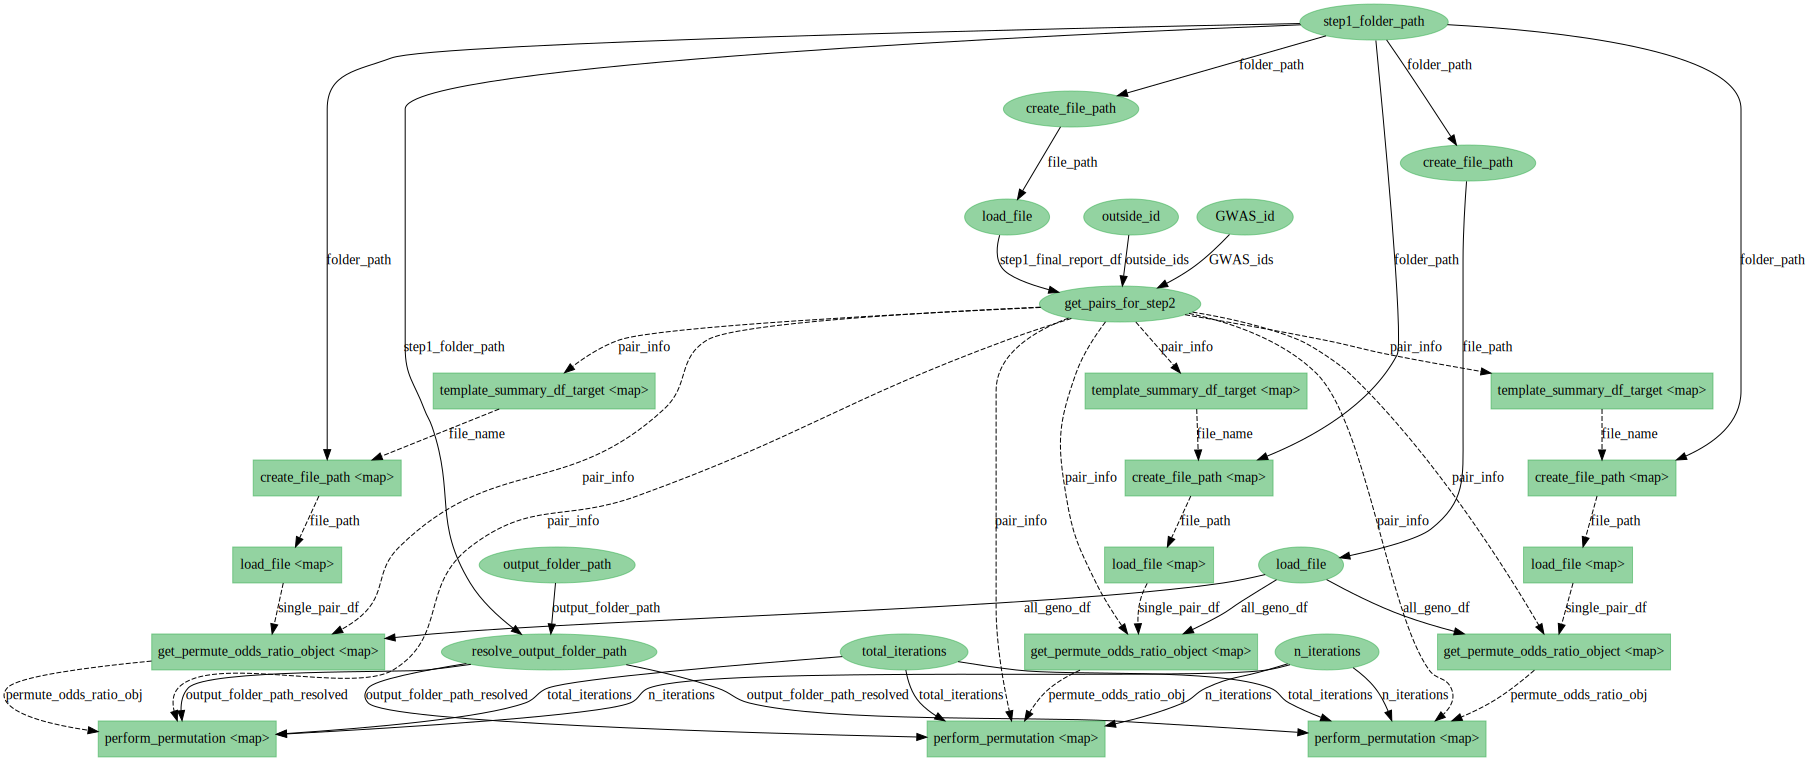

In [14]:
flow.visualize(flow_state = flow_result)

In [152]:
flow_result.result

{<Task: template_summary_df_target>: <Mapped: "Ready to proceed with mapping.">,
 <Task: create_file_path>: <Mapped: "Ready to proceed with mapping.">,
 <Task: get_permute_odds_ratio_object>: <Mapped: "Ready to proceed with mapping.">,
 <Task: create_file_path>: <Success: "Task run succeeded.">,
 <Task: get_pairs_for_step2>: <Success: "Task run succeeded.">,
 <Task: load_file>: <Success: "Task run succeeded.">,
 <Parameter: step1_folder_path>: <Success: "Task run succeeded.">,
 <Parameter: GWAS_id>: <Success: "Task run succeeded.">,
 <Task: load_file>: <Mapped: "Ready to proceed with mapping.">}

In [252]:
flow_result.result[output_folder_path_resolved].result

'/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/test_prefect/'

In [192]:
flow_result.result[all_geno_df].result

first,alleleA,alleleB,AA,AB,BB
id_col,,,,,
rs77948203,G,A,GG,AG,AA
rs1014626,C,T,CC,CT,TT
rs9610458,C,T,CC,CT,TT
rs5762201,A,G,AA,AG,GG
rs1004237,C,T,CC,CT,TT
rs134490,C,T,CC,CT,TT
rs4821519,G,C,GG,CG,CC
rs1003500,C,T,CC,CT,TT
rs5756405,A,G,AA,AG,GG


In [113]:
list(flow_result.result.items())[-1][1].result#[file_path_template]

['//snp_pairs_folders/rs134490/rs134490_rs5762201/single_pair_data_cache_df.parquet',
 'l/snp_pairs_folders/rs5756405/rs5756405_rs4821519/single_pair_data_cache_df.parquet',
 'a/snp_pairs_folders/rs9610458/rs9610458_rs77948203/single_pair_data_cache_df.parquet']

In [57]:
flow_result.result[step1_final_report_df].result

<LocalResult:        GWAS_id   outside_id  GWAS_chrom  outside_chrom  \
0   rs10853845  rs201338837          22             22   
1    rs2253675  rs201338837          22             22   
2    rs2331964  rs201338837          22             22   
3   rs10853845     rs229502          22             22   
4   rs10853845  rs183032559          22             22   
..         ...          ...         ...            ...   
58   rs9610458   rs77948203          22             22   
59   rs9610458   rs77948203          22             22   
60   rs9610458   rs77948203          22             22   
61   rs9610458   rs77948203          22             22   
62   rs9610458   rs77948203          22             22   

    found_in_genetic_file_GWAS  found_in_genetic_file_outside GWAS_id_geno  \
0                            0                              0          NaN   
1                            0                              0          NaN   
2                            0                         